In [2]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [3]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_4/models/epoch_28.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_4/data/test_data.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_4/models/epoch_28.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [4]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [5]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [6]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/75 [00:00<?, ?it/s]

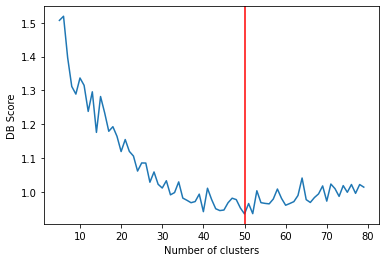

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}


In [7]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

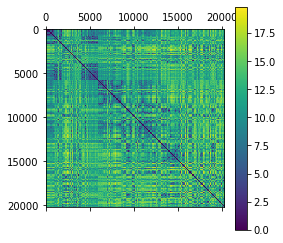

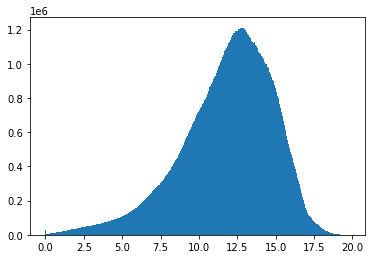

In [10]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

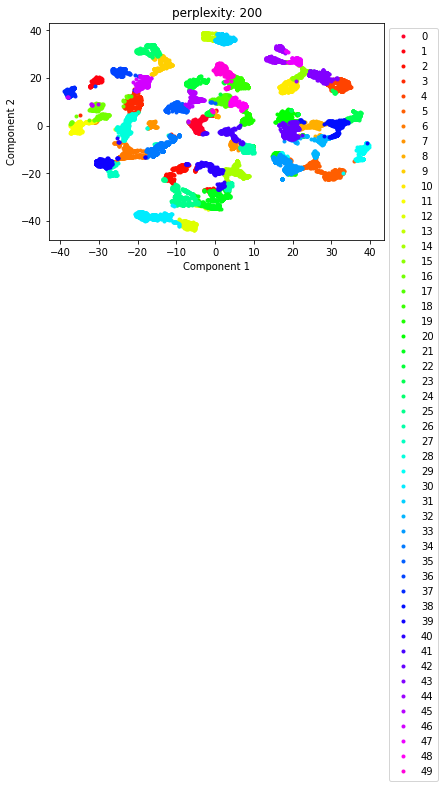

In [11]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [26]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [27]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [28]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [29]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 10

In [30]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9745725126891046


In [31]:
losses = []
accs = []
sparsity = []

In [32]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.25424625870179246
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.988950276243094
layer 5: 0.7726174033149171
layer 6: 0.5562845303867403
layer 7: 0.38630870165745856
layer 8: 0.23564830801104977
Epoch: 00 | Batch: 000 / 011 | Total loss: 3.920 | Reg loss: 0.018 | Tree loss: 3.920 | Accuracy: 0.029500 | 0.901 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 3.915 | Reg loss: 0.018 | Tree loss: 3.915 | Accuracy: 0.025000 | 0.878 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 3.912 | Reg loss: 0.018 | Tree loss: 3.912 | Accuracy: 0.022000 | 0.869 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 3.908 | Reg loss: 0.017 | Tree loss: 3.908 | Accuracy: 0.028000 | 0.866 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 3.907 | Reg loss: 0.017 | Tree loss: 3.907 | Accuracy: 0.032000 | 0.865 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 3.901 | Reg loss: 0.017 | Tree loss: 3.901 | Acc

Epoch: 05 | Batch: 000 / 011 | Total loss: 3.894 | Reg loss: 0.015 | Tree loss: 3.894 | Accuracy: 0.052500 | 0.863 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 3.885 | Reg loss: 0.015 | Tree loss: 3.885 | Accuracy: 0.072500 | 0.862 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 3.871 | Reg loss: 0.015 | Tree loss: 3.871 | Accuracy: 0.112000 | 0.862 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 3.858 | Reg loss: 0.015 | Tree loss: 3.858 | Accuracy: 0.110500 | 0.862 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 3.841 | Reg loss: 0.015 | Tree loss: 3.841 | Accuracy: 0.100000 | 0.862 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 3.828 | Reg loss: 0.015 | Tree loss: 3.828 | Accuracy: 0.072500 | 0.862 sec/iter
Epoch: 05 | Batch: 006 / 011 | Total loss: 3.802 | Reg loss: 0.015 | Tree loss: 3.802 | Accuracy: 0.073500 | 0.862 sec/iter
Epoch: 05 | Batch: 007 / 011 | Total loss: 3.792 | Reg loss: 0.016 | Tree loss: 3.792 | Accuracy: 0.062000 | 0.862 sec/iter
Epoch: 0

Epoch: 10 | Batch: 000 / 011 | Total loss: 3.812 | Reg loss: 0.017 | Tree loss: 3.812 | Accuracy: 0.146000 | 0.862 sec/iter
Epoch: 10 | Batch: 001 / 011 | Total loss: 3.777 | Reg loss: 0.017 | Tree loss: 3.777 | Accuracy: 0.138000 | 0.862 sec/iter
Epoch: 10 | Batch: 002 / 011 | Total loss: 3.737 | Reg loss: 0.017 | Tree loss: 3.737 | Accuracy: 0.145500 | 0.862 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 3.694 | Reg loss: 0.017 | Tree loss: 3.694 | Accuracy: 0.141000 | 0.862 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 3.656 | Reg loss: 0.017 | Tree loss: 3.656 | Accuracy: 0.133500 | 0.862 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 3.611 | Reg loss: 0.018 | Tree loss: 3.611 | Accuracy: 0.141500 | 0.862 sec/iter
Epoch: 10 | Batch: 006 / 011 | Total loss: 3.586 | Reg loss: 0.018 | Tree loss: 3.586 | Accuracy: 0.119500 | 0.862 sec/iter
Epoch: 10 | Batch: 007 / 011 | Total loss: 3.561 | Reg loss: 0.018 | Tree loss: 3.561 | Accuracy: 0.114500 | 0.862 sec/iter
Epoch: 1

Epoch: 15 | Batch: 000 / 011 | Total loss: 3.598 | Reg loss: 0.020 | Tree loss: 3.598 | Accuracy: 0.177000 | 0.863 sec/iter
Epoch: 15 | Batch: 001 / 011 | Total loss: 3.560 | Reg loss: 0.020 | Tree loss: 3.560 | Accuracy: 0.169000 | 0.862 sec/iter
Epoch: 15 | Batch: 002 / 011 | Total loss: 3.500 | Reg loss: 0.020 | Tree loss: 3.500 | Accuracy: 0.188000 | 0.862 sec/iter
Epoch: 15 | Batch: 003 / 011 | Total loss: 3.459 | Reg loss: 0.020 | Tree loss: 3.459 | Accuracy: 0.175000 | 0.862 sec/iter
Epoch: 15 | Batch: 004 / 011 | Total loss: 3.399 | Reg loss: 0.020 | Tree loss: 3.399 | Accuracy: 0.186500 | 0.862 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 3.366 | Reg loss: 0.021 | Tree loss: 3.366 | Accuracy: 0.192000 | 0.862 sec/iter
Epoch: 15 | Batch: 006 / 011 | Total loss: 3.339 | Reg loss: 0.021 | Tree loss: 3.339 | Accuracy: 0.173500 | 0.863 sec/iter
Epoch: 15 | Batch: 007 / 011 | Total loss: 3.310 | Reg loss: 0.021 | Tree loss: 3.310 | Accuracy: 0.175500 | 0.863 sec/iter
Epoch: 1

Epoch: 20 | Batch: 000 / 011 | Total loss: 3.357 | Reg loss: 0.023 | Tree loss: 3.357 | Accuracy: 0.214500 | 0.862 sec/iter
Epoch: 20 | Batch: 001 / 011 | Total loss: 3.319 | Reg loss: 0.023 | Tree loss: 3.319 | Accuracy: 0.214500 | 0.862 sec/iter
Epoch: 20 | Batch: 002 / 011 | Total loss: 3.268 | Reg loss: 0.023 | Tree loss: 3.268 | Accuracy: 0.220000 | 0.862 sec/iter
Epoch: 20 | Batch: 003 / 011 | Total loss: 3.225 | Reg loss: 0.023 | Tree loss: 3.225 | Accuracy: 0.230000 | 0.862 sec/iter
Epoch: 20 | Batch: 004 / 011 | Total loss: 3.167 | Reg loss: 0.023 | Tree loss: 3.167 | Accuracy: 0.236500 | 0.862 sec/iter
Epoch: 20 | Batch: 005 / 011 | Total loss: 3.146 | Reg loss: 0.023 | Tree loss: 3.146 | Accuracy: 0.214500 | 0.862 sec/iter
Epoch: 20 | Batch: 006 / 011 | Total loss: 3.126 | Reg loss: 0.023 | Tree loss: 3.126 | Accuracy: 0.224500 | 0.862 sec/iter
Epoch: 20 | Batch: 007 / 011 | Total loss: 3.107 | Reg loss: 0.023 | Tree loss: 3.107 | Accuracy: 0.210000 | 0.862 sec/iter
Epoch: 2

Epoch: 25 | Batch: 000 / 011 | Total loss: 3.184 | Reg loss: 0.025 | Tree loss: 3.184 | Accuracy: 0.213500 | 0.862 sec/iter
Epoch: 25 | Batch: 001 / 011 | Total loss: 3.153 | Reg loss: 0.025 | Tree loss: 3.153 | Accuracy: 0.198500 | 0.862 sec/iter
Epoch: 25 | Batch: 002 / 011 | Total loss: 3.095 | Reg loss: 0.025 | Tree loss: 3.095 | Accuracy: 0.227500 | 0.862 sec/iter
Epoch: 25 | Batch: 003 / 011 | Total loss: 3.050 | Reg loss: 0.025 | Tree loss: 3.050 | Accuracy: 0.244000 | 0.862 sec/iter
Epoch: 25 | Batch: 004 / 011 | Total loss: 3.006 | Reg loss: 0.025 | Tree loss: 3.006 | Accuracy: 0.240000 | 0.862 sec/iter
Epoch: 25 | Batch: 005 / 011 | Total loss: 2.992 | Reg loss: 0.025 | Tree loss: 2.992 | Accuracy: 0.237500 | 0.862 sec/iter
Epoch: 25 | Batch: 006 / 011 | Total loss: 2.963 | Reg loss: 0.025 | Tree loss: 2.963 | Accuracy: 0.237500 | 0.862 sec/iter
Epoch: 25 | Batch: 007 / 011 | Total loss: 2.953 | Reg loss: 0.025 | Tree loss: 2.953 | Accuracy: 0.225000 | 0.862 sec/iter
Epoch: 2

Epoch: 30 | Batch: 000 / 011 | Total loss: 3.060 | Reg loss: 0.027 | Tree loss: 3.060 | Accuracy: 0.223500 | 0.862 sec/iter
Epoch: 30 | Batch: 001 / 011 | Total loss: 3.001 | Reg loss: 0.027 | Tree loss: 3.001 | Accuracy: 0.233000 | 0.862 sec/iter
Epoch: 30 | Batch: 002 / 011 | Total loss: 2.965 | Reg loss: 0.027 | Tree loss: 2.965 | Accuracy: 0.238500 | 0.862 sec/iter
Epoch: 30 | Batch: 003 / 011 | Total loss: 2.917 | Reg loss: 0.027 | Tree loss: 2.917 | Accuracy: 0.256500 | 0.862 sec/iter
Epoch: 30 | Batch: 004 / 011 | Total loss: 2.889 | Reg loss: 0.027 | Tree loss: 2.889 | Accuracy: 0.258500 | 0.862 sec/iter
Epoch: 30 | Batch: 005 / 011 | Total loss: 2.859 | Reg loss: 0.027 | Tree loss: 2.859 | Accuracy: 0.237500 | 0.862 sec/iter
Epoch: 30 | Batch: 006 / 011 | Total loss: 2.842 | Reg loss: 0.027 | Tree loss: 2.842 | Accuracy: 0.237500 | 0.862 sec/iter
Epoch: 30 | Batch: 007 / 011 | Total loss: 2.846 | Reg loss: 0.027 | Tree loss: 2.846 | Accuracy: 0.216000 | 0.862 sec/iter
Epoch: 3

Epoch: 35 | Batch: 000 / 011 | Total loss: 2.948 | Reg loss: 0.028 | Tree loss: 2.948 | Accuracy: 0.270500 | 0.862 sec/iter
Epoch: 35 | Batch: 001 / 011 | Total loss: 2.907 | Reg loss: 0.028 | Tree loss: 2.907 | Accuracy: 0.275000 | 0.862 sec/iter
Epoch: 35 | Batch: 002 / 011 | Total loss: 2.873 | Reg loss: 0.028 | Tree loss: 2.873 | Accuracy: 0.278000 | 0.862 sec/iter
Epoch: 35 | Batch: 003 / 011 | Total loss: 2.815 | Reg loss: 0.028 | Tree loss: 2.815 | Accuracy: 0.276000 | 0.862 sec/iter
Epoch: 35 | Batch: 004 / 011 | Total loss: 2.793 | Reg loss: 0.028 | Tree loss: 2.793 | Accuracy: 0.254000 | 0.862 sec/iter
Epoch: 35 | Batch: 005 / 011 | Total loss: 2.765 | Reg loss: 0.028 | Tree loss: 2.765 | Accuracy: 0.255500 | 0.862 sec/iter
Epoch: 35 | Batch: 006 / 011 | Total loss: 2.756 | Reg loss: 0.028 | Tree loss: 2.756 | Accuracy: 0.226000 | 0.862 sec/iter
Epoch: 35 | Batch: 007 / 011 | Total loss: 2.727 | Reg loss: 0.028 | Tree loss: 2.727 | Accuracy: 0.238000 | 0.862 sec/iter
Epoch: 3

Epoch: 40 | Batch: 000 / 011 | Total loss: 2.858 | Reg loss: 0.029 | Tree loss: 2.858 | Accuracy: 0.275500 | 0.862 sec/iter
Epoch: 40 | Batch: 001 / 011 | Total loss: 2.848 | Reg loss: 0.029 | Tree loss: 2.848 | Accuracy: 0.273000 | 0.862 sec/iter
Epoch: 40 | Batch: 002 / 011 | Total loss: 2.779 | Reg loss: 0.029 | Tree loss: 2.779 | Accuracy: 0.300000 | 0.862 sec/iter
Epoch: 40 | Batch: 003 / 011 | Total loss: 2.763 | Reg loss: 0.029 | Tree loss: 2.763 | Accuracy: 0.280000 | 0.862 sec/iter
Epoch: 40 | Batch: 004 / 011 | Total loss: 2.716 | Reg loss: 0.029 | Tree loss: 2.716 | Accuracy: 0.282000 | 0.862 sec/iter
Epoch: 40 | Batch: 005 / 011 | Total loss: 2.685 | Reg loss: 0.029 | Tree loss: 2.685 | Accuracy: 0.269000 | 0.862 sec/iter
Epoch: 40 | Batch: 006 / 011 | Total loss: 2.668 | Reg loss: 0.029 | Tree loss: 2.668 | Accuracy: 0.251500 | 0.862 sec/iter
Epoch: 40 | Batch: 007 / 011 | Total loss: 2.646 | Reg loss: 0.029 | Tree loss: 2.646 | Accuracy: 0.247000 | 0.862 sec/iter
Epoch: 4

Epoch: 45 | Batch: 000 / 011 | Total loss: 2.802 | Reg loss: 0.030 | Tree loss: 2.802 | Accuracy: 0.284000 | 0.862 sec/iter
Epoch: 45 | Batch: 001 / 011 | Total loss: 2.784 | Reg loss: 0.030 | Tree loss: 2.784 | Accuracy: 0.270500 | 0.862 sec/iter
Epoch: 45 | Batch: 002 / 011 | Total loss: 2.722 | Reg loss: 0.030 | Tree loss: 2.722 | Accuracy: 0.294500 | 0.862 sec/iter
Epoch: 45 | Batch: 003 / 011 | Total loss: 2.694 | Reg loss: 0.030 | Tree loss: 2.694 | Accuracy: 0.279500 | 0.862 sec/iter
Epoch: 45 | Batch: 004 / 011 | Total loss: 2.655 | Reg loss: 0.030 | Tree loss: 2.655 | Accuracy: 0.280000 | 0.862 sec/iter
Epoch: 45 | Batch: 005 / 011 | Total loss: 2.640 | Reg loss: 0.030 | Tree loss: 2.640 | Accuracy: 0.257500 | 0.862 sec/iter
Epoch: 45 | Batch: 006 / 011 | Total loss: 2.576 | Reg loss: 0.030 | Tree loss: 2.576 | Accuracy: 0.264000 | 0.862 sec/iter
Epoch: 45 | Batch: 007 / 011 | Total loss: 2.608 | Reg loss: 0.030 | Tree loss: 2.608 | Accuracy: 0.231500 | 0.862 sec/iter
Epoch: 4

Epoch: 50 | Batch: 000 / 011 | Total loss: 2.751 | Reg loss: 0.031 | Tree loss: 2.751 | Accuracy: 0.261000 | 0.862 sec/iter
Epoch: 50 | Batch: 001 / 011 | Total loss: 2.700 | Reg loss: 0.031 | Tree loss: 2.700 | Accuracy: 0.295500 | 0.862 sec/iter
Epoch: 50 | Batch: 002 / 011 | Total loss: 2.661 | Reg loss: 0.031 | Tree loss: 2.661 | Accuracy: 0.278500 | 0.862 sec/iter
Epoch: 50 | Batch: 003 / 011 | Total loss: 2.643 | Reg loss: 0.031 | Tree loss: 2.643 | Accuracy: 0.281000 | 0.862 sec/iter
Epoch: 50 | Batch: 004 / 011 | Total loss: 2.610 | Reg loss: 0.031 | Tree loss: 2.610 | Accuracy: 0.272000 | 0.862 sec/iter
Epoch: 50 | Batch: 005 / 011 | Total loss: 2.587 | Reg loss: 0.031 | Tree loss: 2.587 | Accuracy: 0.274000 | 0.862 sec/iter
Epoch: 50 | Batch: 006 / 011 | Total loss: 2.561 | Reg loss: 0.031 | Tree loss: 2.561 | Accuracy: 0.254000 | 0.862 sec/iter
Epoch: 50 | Batch: 007 / 011 | Total loss: 2.581 | Reg loss: 0.031 | Tree loss: 2.581 | Accuracy: 0.244000 | 0.862 sec/iter
Epoch: 5

Epoch: 55 | Batch: 000 / 011 | Total loss: 2.704 | Reg loss: 0.032 | Tree loss: 2.704 | Accuracy: 0.280000 | 0.862 sec/iter
Epoch: 55 | Batch: 001 / 011 | Total loss: 2.659 | Reg loss: 0.032 | Tree loss: 2.659 | Accuracy: 0.293000 | 0.862 sec/iter
Epoch: 55 | Batch: 002 / 011 | Total loss: 2.633 | Reg loss: 0.032 | Tree loss: 2.633 | Accuracy: 0.273500 | 0.862 sec/iter
Epoch: 55 | Batch: 003 / 011 | Total loss: 2.614 | Reg loss: 0.032 | Tree loss: 2.614 | Accuracy: 0.285000 | 0.862 sec/iter
Epoch: 55 | Batch: 004 / 011 | Total loss: 2.585 | Reg loss: 0.032 | Tree loss: 2.585 | Accuracy: 0.281000 | 0.862 sec/iter
Epoch: 55 | Batch: 005 / 011 | Total loss: 2.525 | Reg loss: 0.032 | Tree loss: 2.525 | Accuracy: 0.299000 | 0.862 sec/iter
Epoch: 55 | Batch: 006 / 011 | Total loss: 2.524 | Reg loss: 0.032 | Tree loss: 2.524 | Accuracy: 0.288500 | 0.862 sec/iter
Epoch: 55 | Batch: 007 / 011 | Total loss: 2.513 | Reg loss: 0.032 | Tree loss: 2.513 | Accuracy: 0.264000 | 0.862 sec/iter
Epoch: 5

Epoch: 60 | Batch: 000 / 011 | Total loss: 2.660 | Reg loss: 0.033 | Tree loss: 2.660 | Accuracy: 0.286500 | 0.862 sec/iter
Epoch: 60 | Batch: 001 / 011 | Total loss: 2.608 | Reg loss: 0.033 | Tree loss: 2.608 | Accuracy: 0.303000 | 0.862 sec/iter
Epoch: 60 | Batch: 002 / 011 | Total loss: 2.595 | Reg loss: 0.033 | Tree loss: 2.595 | Accuracy: 0.303000 | 0.862 sec/iter
Epoch: 60 | Batch: 003 / 011 | Total loss: 2.591 | Reg loss: 0.033 | Tree loss: 2.591 | Accuracy: 0.283500 | 0.862 sec/iter
Epoch: 60 | Batch: 004 / 011 | Total loss: 2.516 | Reg loss: 0.033 | Tree loss: 2.516 | Accuracy: 0.304000 | 0.862 sec/iter
Epoch: 60 | Batch: 005 / 011 | Total loss: 2.522 | Reg loss: 0.033 | Tree loss: 2.522 | Accuracy: 0.279500 | 0.862 sec/iter
Epoch: 60 | Batch: 006 / 011 | Total loss: 2.508 | Reg loss: 0.033 | Tree loss: 2.508 | Accuracy: 0.292000 | 0.862 sec/iter
Epoch: 60 | Batch: 007 / 011 | Total loss: 2.479 | Reg loss: 0.033 | Tree loss: 2.479 | Accuracy: 0.282500 | 0.862 sec/iter
Epoch: 6

Epoch: 65 | Batch: 000 / 011 | Total loss: 2.628 | Reg loss: 0.033 | Tree loss: 2.628 | Accuracy: 0.297500 | 0.862 sec/iter
Epoch: 65 | Batch: 001 / 011 | Total loss: 2.624 | Reg loss: 0.033 | Tree loss: 2.624 | Accuracy: 0.290000 | 0.862 sec/iter
Epoch: 65 | Batch: 002 / 011 | Total loss: 2.545 | Reg loss: 0.033 | Tree loss: 2.545 | Accuracy: 0.318000 | 0.862 sec/iter
Epoch: 65 | Batch: 003 / 011 | Total loss: 2.491 | Reg loss: 0.033 | Tree loss: 2.491 | Accuracy: 0.315500 | 0.862 sec/iter
Epoch: 65 | Batch: 004 / 011 | Total loss: 2.514 | Reg loss: 0.033 | Tree loss: 2.514 | Accuracy: 0.297500 | 0.862 sec/iter
Epoch: 65 | Batch: 005 / 011 | Total loss: 2.470 | Reg loss: 0.033 | Tree loss: 2.470 | Accuracy: 0.310000 | 0.862 sec/iter
Epoch: 65 | Batch: 006 / 011 | Total loss: 2.477 | Reg loss: 0.033 | Tree loss: 2.477 | Accuracy: 0.284500 | 0.862 sec/iter
Epoch: 65 | Batch: 007 / 011 | Total loss: 2.457 | Reg loss: 0.033 | Tree loss: 2.457 | Accuracy: 0.286000 | 0.862 sec/iter
Epoch: 6

Epoch: 70 | Batch: 000 / 011 | Total loss: 2.625 | Reg loss: 0.034 | Tree loss: 2.625 | Accuracy: 0.289000 | 0.862 sec/iter
Epoch: 70 | Batch: 001 / 011 | Total loss: 2.564 | Reg loss: 0.034 | Tree loss: 2.564 | Accuracy: 0.304500 | 0.862 sec/iter
Epoch: 70 | Batch: 002 / 011 | Total loss: 2.521 | Reg loss: 0.034 | Tree loss: 2.521 | Accuracy: 0.317000 | 0.862 sec/iter
Epoch: 70 | Batch: 003 / 011 | Total loss: 2.503 | Reg loss: 0.034 | Tree loss: 2.503 | Accuracy: 0.292000 | 0.862 sec/iter
Epoch: 70 | Batch: 004 / 011 | Total loss: 2.472 | Reg loss: 0.034 | Tree loss: 2.472 | Accuracy: 0.293000 | 0.862 sec/iter
Epoch: 70 | Batch: 005 / 011 | Total loss: 2.466 | Reg loss: 0.034 | Tree loss: 2.466 | Accuracy: 0.289500 | 0.862 sec/iter
Epoch: 70 | Batch: 006 / 011 | Total loss: 2.426 | Reg loss: 0.034 | Tree loss: 2.426 | Accuracy: 0.297000 | 0.862 sec/iter
Epoch: 70 | Batch: 007 / 011 | Total loss: 2.444 | Reg loss: 0.034 | Tree loss: 2.444 | Accuracy: 0.282500 | 0.862 sec/iter
Epoch: 7

Epoch: 75 | Batch: 000 / 011 | Total loss: 2.553 | Reg loss: 0.034 | Tree loss: 2.553 | Accuracy: 0.308000 | 0.862 sec/iter
Epoch: 75 | Batch: 001 / 011 | Total loss: 2.535 | Reg loss: 0.034 | Tree loss: 2.535 | Accuracy: 0.310000 | 0.862 sec/iter
Epoch: 75 | Batch: 002 / 011 | Total loss: 2.510 | Reg loss: 0.034 | Tree loss: 2.510 | Accuracy: 0.312000 | 0.862 sec/iter
Epoch: 75 | Batch: 003 / 011 | Total loss: 2.486 | Reg loss: 0.034 | Tree loss: 2.486 | Accuracy: 0.311000 | 0.862 sec/iter
Epoch: 75 | Batch: 004 / 011 | Total loss: 2.447 | Reg loss: 0.034 | Tree loss: 2.447 | Accuracy: 0.306000 | 0.862 sec/iter
Epoch: 75 | Batch: 005 / 011 | Total loss: 2.432 | Reg loss: 0.034 | Tree loss: 2.432 | Accuracy: 0.299500 | 0.862 sec/iter
Epoch: 75 | Batch: 006 / 011 | Total loss: 2.414 | Reg loss: 0.035 | Tree loss: 2.414 | Accuracy: 0.291500 | 0.862 sec/iter
Epoch: 75 | Batch: 007 / 011 | Total loss: 2.404 | Reg loss: 0.035 | Tree loss: 2.404 | Accuracy: 0.282000 | 0.862 sec/iter
Epoch: 7

Epoch: 80 | Batch: 000 / 011 | Total loss: 2.562 | Reg loss: 0.035 | Tree loss: 2.562 | Accuracy: 0.286000 | 0.863 sec/iter
Epoch: 80 | Batch: 001 / 011 | Total loss: 2.528 | Reg loss: 0.035 | Tree loss: 2.528 | Accuracy: 0.303500 | 0.863 sec/iter
Epoch: 80 | Batch: 002 / 011 | Total loss: 2.485 | Reg loss: 0.035 | Tree loss: 2.485 | Accuracy: 0.309500 | 0.863 sec/iter
Epoch: 80 | Batch: 003 / 011 | Total loss: 2.451 | Reg loss: 0.035 | Tree loss: 2.451 | Accuracy: 0.310500 | 0.863 sec/iter
Epoch: 80 | Batch: 004 / 011 | Total loss: 2.447 | Reg loss: 0.035 | Tree loss: 2.447 | Accuracy: 0.294500 | 0.864 sec/iter
Epoch: 80 | Batch: 005 / 011 | Total loss: 2.394 | Reg loss: 0.035 | Tree loss: 2.394 | Accuracy: 0.300500 | 0.864 sec/iter
Epoch: 80 | Batch: 006 / 011 | Total loss: 2.374 | Reg loss: 0.035 | Tree loss: 2.374 | Accuracy: 0.310000 | 0.864 sec/iter
Epoch: 80 | Batch: 007 / 011 | Total loss: 2.380 | Reg loss: 0.035 | Tree loss: 2.380 | Accuracy: 0.276000 | 0.864 sec/iter
Epoch: 8

Epoch: 85 | Batch: 000 / 011 | Total loss: 2.533 | Reg loss: 0.035 | Tree loss: 2.533 | Accuracy: 0.292000 | 0.865 sec/iter
Epoch: 85 | Batch: 001 / 011 | Total loss: 2.509 | Reg loss: 0.035 | Tree loss: 2.509 | Accuracy: 0.306500 | 0.865 sec/iter
Epoch: 85 | Batch: 002 / 011 | Total loss: 2.455 | Reg loss: 0.035 | Tree loss: 2.455 | Accuracy: 0.308500 | 0.866 sec/iter
Epoch: 85 | Batch: 003 / 011 | Total loss: 2.453 | Reg loss: 0.035 | Tree loss: 2.453 | Accuracy: 0.307500 | 0.866 sec/iter
Epoch: 85 | Batch: 004 / 011 | Total loss: 2.415 | Reg loss: 0.036 | Tree loss: 2.415 | Accuracy: 0.316500 | 0.866 sec/iter
Epoch: 85 | Batch: 005 / 011 | Total loss: 2.425 | Reg loss: 0.036 | Tree loss: 2.425 | Accuracy: 0.268000 | 0.866 sec/iter
Epoch: 85 | Batch: 006 / 011 | Total loss: 2.378 | Reg loss: 0.036 | Tree loss: 2.378 | Accuracy: 0.283000 | 0.866 sec/iter
Epoch: 85 | Batch: 007 / 011 | Total loss: 2.357 | Reg loss: 0.036 | Tree loss: 2.357 | Accuracy: 0.279500 | 0.866 sec/iter
Epoch: 8

Epoch: 90 | Batch: 000 / 011 | Total loss: 2.506 | Reg loss: 0.036 | Tree loss: 2.506 | Accuracy: 0.314500 | 0.872 sec/iter
Epoch: 90 | Batch: 001 / 011 | Total loss: 2.465 | Reg loss: 0.036 | Tree loss: 2.465 | Accuracy: 0.314000 | 0.872 sec/iter
Epoch: 90 | Batch: 002 / 011 | Total loss: 2.449 | Reg loss: 0.036 | Tree loss: 2.449 | Accuracy: 0.305500 | 0.872 sec/iter
Epoch: 90 | Batch: 003 / 011 | Total loss: 2.402 | Reg loss: 0.036 | Tree loss: 2.402 | Accuracy: 0.319500 | 0.872 sec/iter
Epoch: 90 | Batch: 004 / 011 | Total loss: 2.389 | Reg loss: 0.036 | Tree loss: 2.389 | Accuracy: 0.301000 | 0.872 sec/iter
Epoch: 90 | Batch: 005 / 011 | Total loss: 2.408 | Reg loss: 0.036 | Tree loss: 2.408 | Accuracy: 0.291000 | 0.873 sec/iter
Epoch: 90 | Batch: 006 / 011 | Total loss: 2.375 | Reg loss: 0.036 | Tree loss: 2.375 | Accuracy: 0.258500 | 0.873 sec/iter
Epoch: 90 | Batch: 007 / 011 | Total loss: 2.356 | Reg loss: 0.036 | Tree loss: 2.356 | Accuracy: 0.270500 | 0.873 sec/iter
Epoch: 9

Epoch: 95 | Batch: 000 / 011 | Total loss: 2.492 | Reg loss: 0.036 | Tree loss: 2.492 | Accuracy: 0.300500 | 0.879 sec/iter
Epoch: 95 | Batch: 001 / 011 | Total loss: 2.448 | Reg loss: 0.036 | Tree loss: 2.448 | Accuracy: 0.323500 | 0.879 sec/iter
Epoch: 95 | Batch: 002 / 011 | Total loss: 2.427 | Reg loss: 0.036 | Tree loss: 2.427 | Accuracy: 0.312500 | 0.88 sec/iter
Epoch: 95 | Batch: 003 / 011 | Total loss: 2.402 | Reg loss: 0.036 | Tree loss: 2.402 | Accuracy: 0.305000 | 0.88 sec/iter
Epoch: 95 | Batch: 004 / 011 | Total loss: 2.391 | Reg loss: 0.036 | Tree loss: 2.391 | Accuracy: 0.309500 | 0.881 sec/iter
Epoch: 95 | Batch: 005 / 011 | Total loss: 2.364 | Reg loss: 0.037 | Tree loss: 2.364 | Accuracy: 0.294000 | 0.881 sec/iter
Epoch: 95 | Batch: 006 / 011 | Total loss: 2.340 | Reg loss: 0.037 | Tree loss: 2.340 | Accuracy: 0.312500 | 0.882 sec/iter
Epoch: 95 | Batch: 007 / 011 | Total loss: 2.337 | Reg loss: 0.037 | Tree loss: 2.337 | Accuracy: 0.303000 | 0.883 sec/iter
Epoch: 95 

Epoch: 100 | Batch: 000 / 011 | Total loss: 2.471 | Reg loss: 0.037 | Tree loss: 2.471 | Accuracy: 0.284000 | 0.908 sec/iter
Epoch: 100 | Batch: 001 / 011 | Total loss: 2.446 | Reg loss: 0.037 | Tree loss: 2.446 | Accuracy: 0.306500 | 0.909 sec/iter
Epoch: 100 | Batch: 002 / 011 | Total loss: 2.434 | Reg loss: 0.037 | Tree loss: 2.434 | Accuracy: 0.308000 | 0.909 sec/iter
Epoch: 100 | Batch: 003 / 011 | Total loss: 2.388 | Reg loss: 0.037 | Tree loss: 2.388 | Accuracy: 0.324500 | 0.91 sec/iter
Epoch: 100 | Batch: 004 / 011 | Total loss: 2.360 | Reg loss: 0.037 | Tree loss: 2.360 | Accuracy: 0.317500 | 0.91 sec/iter
Epoch: 100 | Batch: 005 / 011 | Total loss: 2.340 | Reg loss: 0.037 | Tree loss: 2.340 | Accuracy: 0.326500 | 0.911 sec/iter
Epoch: 100 | Batch: 006 / 011 | Total loss: 2.344 | Reg loss: 0.037 | Tree loss: 2.344 | Accuracy: 0.309000 | 0.912 sec/iter
Epoch: 100 | Batch: 007 / 011 | Total loss: 2.333 | Reg loss: 0.037 | Tree loss: 2.333 | Accuracy: 0.293000 | 0.912 sec/iter
Ep

Epoch: 105 | Batch: 000 / 011 | Total loss: 2.449 | Reg loss: 0.037 | Tree loss: 2.449 | Accuracy: 0.291000 | 0.936 sec/iter
Epoch: 105 | Batch: 001 / 011 | Total loss: 2.421 | Reg loss: 0.037 | Tree loss: 2.421 | Accuracy: 0.307500 | 0.936 sec/iter
Epoch: 105 | Batch: 002 / 011 | Total loss: 2.418 | Reg loss: 0.037 | Tree loss: 2.418 | Accuracy: 0.307000 | 0.937 sec/iter
Epoch: 105 | Batch: 003 / 011 | Total loss: 2.399 | Reg loss: 0.037 | Tree loss: 2.399 | Accuracy: 0.314000 | 0.937 sec/iter
Epoch: 105 | Batch: 004 / 011 | Total loss: 2.357 | Reg loss: 0.037 | Tree loss: 2.357 | Accuracy: 0.311500 | 0.937 sec/iter
Epoch: 105 | Batch: 005 / 011 | Total loss: 2.320 | Reg loss: 0.037 | Tree loss: 2.320 | Accuracy: 0.338000 | 0.937 sec/iter
Epoch: 105 | Batch: 006 / 011 | Total loss: 2.320 | Reg loss: 0.037 | Tree loss: 2.320 | Accuracy: 0.305000 | 0.938 sec/iter
Epoch: 105 | Batch: 007 / 011 | Total loss: 2.319 | Reg loss: 0.037 | Tree loss: 2.319 | Accuracy: 0.301500 | 0.938 sec/iter


Epoch: 110 | Batch: 000 / 011 | Total loss: 2.443 | Reg loss: 0.038 | Tree loss: 2.443 | Accuracy: 0.312500 | 0.958 sec/iter
Epoch: 110 | Batch: 001 / 011 | Total loss: 2.416 | Reg loss: 0.038 | Tree loss: 2.416 | Accuracy: 0.320000 | 0.958 sec/iter
Epoch: 110 | Batch: 002 / 011 | Total loss: 2.399 | Reg loss: 0.038 | Tree loss: 2.399 | Accuracy: 0.320500 | 0.958 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 2.376 | Reg loss: 0.038 | Tree loss: 2.376 | Accuracy: 0.300000 | 0.959 sec/iter
Epoch: 110 | Batch: 004 / 011 | Total loss: 2.320 | Reg loss: 0.038 | Tree loss: 2.320 | Accuracy: 0.323500 | 0.959 sec/iter
Epoch: 110 | Batch: 005 / 011 | Total loss: 2.326 | Reg loss: 0.038 | Tree loss: 2.326 | Accuracy: 0.311000 | 0.96 sec/iter
Epoch: 110 | Batch: 006 / 011 | Total loss: 2.316 | Reg loss: 0.038 | Tree loss: 2.316 | Accuracy: 0.308500 | 0.96 sec/iter
Epoch: 110 | Batch: 007 / 011 | Total loss: 2.314 | Reg loss: 0.038 | Tree loss: 2.314 | Accuracy: 0.283500 | 0.96 sec/iter
Epo

Epoch: 115 | Batch: 000 / 011 | Total loss: 2.464 | Reg loss: 0.038 | Tree loss: 2.464 | Accuracy: 0.294000 | 0.982 sec/iter
Epoch: 115 | Batch: 001 / 011 | Total loss: 2.421 | Reg loss: 0.038 | Tree loss: 2.421 | Accuracy: 0.297500 | 0.982 sec/iter
Epoch: 115 | Batch: 002 / 011 | Total loss: 2.406 | Reg loss: 0.038 | Tree loss: 2.406 | Accuracy: 0.305000 | 0.983 sec/iter
Epoch: 115 | Batch: 003 / 011 | Total loss: 2.349 | Reg loss: 0.038 | Tree loss: 2.349 | Accuracy: 0.316000 | 0.983 sec/iter
Epoch: 115 | Batch: 004 / 011 | Total loss: 2.333 | Reg loss: 0.038 | Tree loss: 2.333 | Accuracy: 0.324500 | 0.983 sec/iter
Epoch: 115 | Batch: 005 / 011 | Total loss: 2.301 | Reg loss: 0.038 | Tree loss: 2.301 | Accuracy: 0.322000 | 0.984 sec/iter
Epoch: 115 | Batch: 006 / 011 | Total loss: 2.293 | Reg loss: 0.038 | Tree loss: 2.293 | Accuracy: 0.303000 | 0.984 sec/iter
Epoch: 115 | Batch: 007 / 011 | Total loss: 2.298 | Reg loss: 0.038 | Tree loss: 2.298 | Accuracy: 0.314500 | 0.985 sec/iter


Epoch: 120 | Batch: 000 / 011 | Total loss: 2.435 | Reg loss: 0.038 | Tree loss: 2.435 | Accuracy: 0.301500 | 1.005 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 2.428 | Reg loss: 0.038 | Tree loss: 2.428 | Accuracy: 0.294500 | 1.005 sec/iter
Epoch: 120 | Batch: 002 / 011 | Total loss: 2.359 | Reg loss: 0.038 | Tree loss: 2.359 | Accuracy: 0.314500 | 1.006 sec/iter
Epoch: 120 | Batch: 003 / 011 | Total loss: 2.340 | Reg loss: 0.039 | Tree loss: 2.340 | Accuracy: 0.326500 | 1.006 sec/iter
Epoch: 120 | Batch: 004 / 011 | Total loss: 2.305 | Reg loss: 0.039 | Tree loss: 2.305 | Accuracy: 0.316500 | 1.006 sec/iter
Epoch: 120 | Batch: 005 / 011 | Total loss: 2.320 | Reg loss: 0.039 | Tree loss: 2.320 | Accuracy: 0.303000 | 1.007 sec/iter
Epoch: 120 | Batch: 006 / 011 | Total loss: 2.313 | Reg loss: 0.039 | Tree loss: 2.313 | Accuracy: 0.286500 | 1.007 sec/iter
Epoch: 120 | Batch: 007 / 011 | Total loss: 2.297 | Reg loss: 0.039 | Tree loss: 2.297 | Accuracy: 0.280000 | 1.007 sec/iter


Epoch: 125 | Batch: 000 / 011 | Total loss: 2.443 | Reg loss: 0.039 | Tree loss: 2.443 | Accuracy: 0.282000 | 1.024 sec/iter
Epoch: 125 | Batch: 001 / 011 | Total loss: 2.382 | Reg loss: 0.039 | Tree loss: 2.382 | Accuracy: 0.310500 | 1.024 sec/iter
Epoch: 125 | Batch: 002 / 011 | Total loss: 2.366 | Reg loss: 0.039 | Tree loss: 2.366 | Accuracy: 0.327500 | 1.025 sec/iter
Epoch: 125 | Batch: 003 / 011 | Total loss: 2.339 | Reg loss: 0.039 | Tree loss: 2.339 | Accuracy: 0.313000 | 1.025 sec/iter
Epoch: 125 | Batch: 004 / 011 | Total loss: 2.308 | Reg loss: 0.039 | Tree loss: 2.308 | Accuracy: 0.319500 | 1.025 sec/iter
Epoch: 125 | Batch: 005 / 011 | Total loss: 2.293 | Reg loss: 0.039 | Tree loss: 2.293 | Accuracy: 0.334000 | 1.026 sec/iter
Epoch: 125 | Batch: 006 / 011 | Total loss: 2.289 | Reg loss: 0.039 | Tree loss: 2.289 | Accuracy: 0.293500 | 1.026 sec/iter
Epoch: 125 | Batch: 007 / 011 | Total loss: 2.284 | Reg loss: 0.039 | Tree loss: 2.284 | Accuracy: 0.285000 | 1.026 sec/iter


Epoch: 130 | Batch: 000 / 011 | Total loss: 2.431 | Reg loss: 0.039 | Tree loss: 2.431 | Accuracy: 0.292000 | 1.039 sec/iter
Epoch: 130 | Batch: 001 / 011 | Total loss: 2.392 | Reg loss: 0.039 | Tree loss: 2.392 | Accuracy: 0.299000 | 1.039 sec/iter
Epoch: 130 | Batch: 002 / 011 | Total loss: 2.352 | Reg loss: 0.039 | Tree loss: 2.352 | Accuracy: 0.307500 | 1.04 sec/iter
Epoch: 130 | Batch: 003 / 011 | Total loss: 2.340 | Reg loss: 0.039 | Tree loss: 2.340 | Accuracy: 0.326500 | 1.04 sec/iter
Epoch: 130 | Batch: 004 / 011 | Total loss: 2.296 | Reg loss: 0.039 | Tree loss: 2.296 | Accuracy: 0.323500 | 1.04 sec/iter
Epoch: 130 | Batch: 005 / 011 | Total loss: 2.309 | Reg loss: 0.039 | Tree loss: 2.309 | Accuracy: 0.314000 | 1.041 sec/iter
Epoch: 130 | Batch: 006 / 011 | Total loss: 2.259 | Reg loss: 0.039 | Tree loss: 2.259 | Accuracy: 0.314500 | 1.041 sec/iter
Epoch: 130 | Batch: 007 / 011 | Total loss: 2.292 | Reg loss: 0.039 | Tree loss: 2.292 | Accuracy: 0.294000 | 1.041 sec/iter
Epo

Epoch: 135 | Batch: 000 / 011 | Total loss: 2.412 | Reg loss: 0.039 | Tree loss: 2.412 | Accuracy: 0.298500 | 1.055 sec/iter
Epoch: 135 | Batch: 001 / 011 | Total loss: 2.386 | Reg loss: 0.039 | Tree loss: 2.386 | Accuracy: 0.316500 | 1.055 sec/iter
Epoch: 135 | Batch: 002 / 011 | Total loss: 2.346 | Reg loss: 0.039 | Tree loss: 2.346 | Accuracy: 0.298500 | 1.056 sec/iter
Epoch: 135 | Batch: 003 / 011 | Total loss: 2.321 | Reg loss: 0.039 | Tree loss: 2.321 | Accuracy: 0.326500 | 1.056 sec/iter
Epoch: 135 | Batch: 004 / 011 | Total loss: 2.312 | Reg loss: 0.039 | Tree loss: 2.312 | Accuracy: 0.291500 | 1.056 sec/iter
Epoch: 135 | Batch: 005 / 011 | Total loss: 2.280 | Reg loss: 0.039 | Tree loss: 2.280 | Accuracy: 0.305500 | 1.057 sec/iter
Epoch: 135 | Batch: 006 / 011 | Total loss: 2.277 | Reg loss: 0.039 | Tree loss: 2.277 | Accuracy: 0.313500 | 1.057 sec/iter
Epoch: 135 | Batch: 007 / 011 | Total loss: 2.266 | Reg loss: 0.039 | Tree loss: 2.266 | Accuracy: 0.306000 | 1.057 sec/iter


Epoch: 140 | Batch: 000 / 011 | Total loss: 2.362 | Reg loss: 0.040 | Tree loss: 2.362 | Accuracy: 0.315500 | 1.07 sec/iter
Epoch: 140 | Batch: 001 / 011 | Total loss: 2.386 | Reg loss: 0.040 | Tree loss: 2.386 | Accuracy: 0.298500 | 1.07 sec/iter
Epoch: 140 | Batch: 002 / 011 | Total loss: 2.364 | Reg loss: 0.040 | Tree loss: 2.364 | Accuracy: 0.323000 | 1.07 sec/iter
Epoch: 140 | Batch: 003 / 011 | Total loss: 2.345 | Reg loss: 0.040 | Tree loss: 2.345 | Accuracy: 0.315000 | 1.07 sec/iter
Epoch: 140 | Batch: 004 / 011 | Total loss: 2.296 | Reg loss: 0.040 | Tree loss: 2.296 | Accuracy: 0.315500 | 1.07 sec/iter
Epoch: 140 | Batch: 005 / 011 | Total loss: 2.296 | Reg loss: 0.040 | Tree loss: 2.296 | Accuracy: 0.305500 | 1.071 sec/iter
Epoch: 140 | Batch: 006 / 011 | Total loss: 2.282 | Reg loss: 0.040 | Tree loss: 2.282 | Accuracy: 0.296000 | 1.071 sec/iter
Epoch: 140 | Batch: 007 / 011 | Total loss: 2.243 | Reg loss: 0.040 | Tree loss: 2.243 | Accuracy: 0.309500 | 1.071 sec/iter
Epoch

Epoch: 145 | Batch: 000 / 011 | Total loss: 2.382 | Reg loss: 0.040 | Tree loss: 2.382 | Accuracy: 0.299500 | 1.082 sec/iter
Epoch: 145 | Batch: 001 / 011 | Total loss: 2.378 | Reg loss: 0.040 | Tree loss: 2.378 | Accuracy: 0.311000 | 1.082 sec/iter
Epoch: 145 | Batch: 002 / 011 | Total loss: 2.332 | Reg loss: 0.040 | Tree loss: 2.332 | Accuracy: 0.310500 | 1.082 sec/iter
Epoch: 145 | Batch: 003 / 011 | Total loss: 2.321 | Reg loss: 0.040 | Tree loss: 2.321 | Accuracy: 0.323500 | 1.083 sec/iter
Epoch: 145 | Batch: 004 / 011 | Total loss: 2.297 | Reg loss: 0.040 | Tree loss: 2.297 | Accuracy: 0.324000 | 1.083 sec/iter
Epoch: 145 | Batch: 005 / 011 | Total loss: 2.281 | Reg loss: 0.040 | Tree loss: 2.281 | Accuracy: 0.299000 | 1.083 sec/iter
Epoch: 145 | Batch: 006 / 011 | Total loss: 2.265 | Reg loss: 0.040 | Tree loss: 2.265 | Accuracy: 0.317000 | 1.083 sec/iter
Epoch: 145 | Batch: 007 / 011 | Total loss: 2.238 | Reg loss: 0.040 | Tree loss: 2.238 | Accuracy: 0.320000 | 1.083 sec/iter


Epoch: 150 | Batch: 000 / 011 | Total loss: 2.388 | Reg loss: 0.040 | Tree loss: 2.388 | Accuracy: 0.302500 | 1.094 sec/iter
Epoch: 150 | Batch: 001 / 011 | Total loss: 2.363 | Reg loss: 0.040 | Tree loss: 2.363 | Accuracy: 0.309500 | 1.094 sec/iter
Epoch: 150 | Batch: 002 / 011 | Total loss: 2.332 | Reg loss: 0.040 | Tree loss: 2.332 | Accuracy: 0.332000 | 1.095 sec/iter
Epoch: 150 | Batch: 003 / 011 | Total loss: 2.307 | Reg loss: 0.040 | Tree loss: 2.307 | Accuracy: 0.314000 | 1.095 sec/iter
Epoch: 150 | Batch: 004 / 011 | Total loss: 2.295 | Reg loss: 0.040 | Tree loss: 2.295 | Accuracy: 0.310000 | 1.095 sec/iter
Epoch: 150 | Batch: 005 / 011 | Total loss: 2.260 | Reg loss: 0.040 | Tree loss: 2.260 | Accuracy: 0.316500 | 1.095 sec/iter
Epoch: 150 | Batch: 006 / 011 | Total loss: 2.252 | Reg loss: 0.040 | Tree loss: 2.252 | Accuracy: 0.316000 | 1.095 sec/iter
Epoch: 150 | Batch: 007 / 011 | Total loss: 2.260 | Reg loss: 0.040 | Tree loss: 2.260 | Accuracy: 0.295500 | 1.095 sec/iter


Epoch: 155 | Batch: 000 / 011 | Total loss: 2.385 | Reg loss: 0.040 | Tree loss: 2.385 | Accuracy: 0.308500 | 1.106 sec/iter
Epoch: 155 | Batch: 001 / 011 | Total loss: 2.351 | Reg loss: 0.040 | Tree loss: 2.351 | Accuracy: 0.309500 | 1.106 sec/iter
Epoch: 155 | Batch: 002 / 011 | Total loss: 2.325 | Reg loss: 0.040 | Tree loss: 2.325 | Accuracy: 0.303000 | 1.106 sec/iter
Epoch: 155 | Batch: 003 / 011 | Total loss: 2.313 | Reg loss: 0.040 | Tree loss: 2.313 | Accuracy: 0.325000 | 1.106 sec/iter
Epoch: 155 | Batch: 004 / 011 | Total loss: 2.291 | Reg loss: 0.040 | Tree loss: 2.291 | Accuracy: 0.318000 | 1.106 sec/iter
Epoch: 155 | Batch: 005 / 011 | Total loss: 2.269 | Reg loss: 0.040 | Tree loss: 2.269 | Accuracy: 0.311500 | 1.107 sec/iter
Epoch: 155 | Batch: 006 / 011 | Total loss: 2.240 | Reg loss: 0.040 | Tree loss: 2.240 | Accuracy: 0.309500 | 1.107 sec/iter
Epoch: 155 | Batch: 007 / 011 | Total loss: 2.233 | Reg loss: 0.040 | Tree loss: 2.233 | Accuracy: 0.299500 | 1.107 sec/iter


Epoch: 160 | Batch: 000 / 011 | Total loss: 2.386 | Reg loss: 0.040 | Tree loss: 2.386 | Accuracy: 0.301000 | 1.114 sec/iter
Epoch: 160 | Batch: 001 / 011 | Total loss: 2.365 | Reg loss: 0.040 | Tree loss: 2.365 | Accuracy: 0.302500 | 1.114 sec/iter
Epoch: 160 | Batch: 002 / 011 | Total loss: 2.349 | Reg loss: 0.040 | Tree loss: 2.349 | Accuracy: 0.316500 | 1.114 sec/iter
Epoch: 160 | Batch: 003 / 011 | Total loss: 2.275 | Reg loss: 0.040 | Tree loss: 2.275 | Accuracy: 0.315500 | 1.115 sec/iter
Epoch: 160 | Batch: 004 / 011 | Total loss: 2.267 | Reg loss: 0.040 | Tree loss: 2.267 | Accuracy: 0.328000 | 1.115 sec/iter
Epoch: 160 | Batch: 005 / 011 | Total loss: 2.278 | Reg loss: 0.040 | Tree loss: 2.278 | Accuracy: 0.300500 | 1.115 sec/iter
Epoch: 160 | Batch: 006 / 011 | Total loss: 2.252 | Reg loss: 0.040 | Tree loss: 2.252 | Accuracy: 0.303000 | 1.115 sec/iter
Epoch: 160 | Batch: 007 / 011 | Total loss: 2.243 | Reg loss: 0.040 | Tree loss: 2.243 | Accuracy: 0.317000 | 1.115 sec/iter


Epoch: 165 | Batch: 000 / 011 | Total loss: 2.372 | Reg loss: 0.041 | Tree loss: 2.372 | Accuracy: 0.297500 | 1.123 sec/iter
Epoch: 165 | Batch: 001 / 011 | Total loss: 2.333 | Reg loss: 0.041 | Tree loss: 2.333 | Accuracy: 0.306500 | 1.123 sec/iter
Epoch: 165 | Batch: 002 / 011 | Total loss: 2.334 | Reg loss: 0.041 | Tree loss: 2.334 | Accuracy: 0.321000 | 1.123 sec/iter
Epoch: 165 | Batch: 003 / 011 | Total loss: 2.332 | Reg loss: 0.041 | Tree loss: 2.332 | Accuracy: 0.279500 | 1.124 sec/iter
Epoch: 165 | Batch: 004 / 011 | Total loss: 2.278 | Reg loss: 0.041 | Tree loss: 2.278 | Accuracy: 0.321000 | 1.124 sec/iter
Epoch: 165 | Batch: 005 / 011 | Total loss: 2.245 | Reg loss: 0.041 | Tree loss: 2.245 | Accuracy: 0.314500 | 1.124 sec/iter
Epoch: 165 | Batch: 006 / 011 | Total loss: 2.229 | Reg loss: 0.041 | Tree loss: 2.229 | Accuracy: 0.322000 | 1.124 sec/iter
Epoch: 165 | Batch: 007 / 011 | Total loss: 2.250 | Reg loss: 0.041 | Tree loss: 2.250 | Accuracy: 0.312500 | 1.125 sec/iter


Epoch: 170 | Batch: 000 / 011 | Total loss: 2.359 | Reg loss: 0.041 | Tree loss: 2.359 | Accuracy: 0.305000 | 1.133 sec/iter
Epoch: 170 | Batch: 001 / 011 | Total loss: 2.347 | Reg loss: 0.041 | Tree loss: 2.347 | Accuracy: 0.301500 | 1.133 sec/iter
Epoch: 170 | Batch: 002 / 011 | Total loss: 2.313 | Reg loss: 0.041 | Tree loss: 2.313 | Accuracy: 0.331500 | 1.133 sec/iter
Epoch: 170 | Batch: 003 / 011 | Total loss: 2.304 | Reg loss: 0.041 | Tree loss: 2.304 | Accuracy: 0.324000 | 1.133 sec/iter
Epoch: 170 | Batch: 004 / 011 | Total loss: 2.274 | Reg loss: 0.041 | Tree loss: 2.274 | Accuracy: 0.337000 | 1.133 sec/iter
Epoch: 170 | Batch: 005 / 011 | Total loss: 2.246 | Reg loss: 0.041 | Tree loss: 2.246 | Accuracy: 0.319500 | 1.134 sec/iter
Epoch: 170 | Batch: 006 / 011 | Total loss: 2.258 | Reg loss: 0.041 | Tree loss: 2.258 | Accuracy: 0.306000 | 1.134 sec/iter
Epoch: 170 | Batch: 007 / 011 | Total loss: 2.253 | Reg loss: 0.041 | Tree loss: 2.253 | Accuracy: 0.300000 | 1.134 sec/iter


Epoch: 175 | Batch: 000 / 011 | Total loss: 2.384 | Reg loss: 0.041 | Tree loss: 2.384 | Accuracy: 0.309500 | 1.143 sec/iter
Epoch: 175 | Batch: 001 / 011 | Total loss: 2.335 | Reg loss: 0.041 | Tree loss: 2.335 | Accuracy: 0.318000 | 1.143 sec/iter
Epoch: 175 | Batch: 002 / 011 | Total loss: 2.318 | Reg loss: 0.041 | Tree loss: 2.318 | Accuracy: 0.325500 | 1.143 sec/iter
Epoch: 175 | Batch: 003 / 011 | Total loss: 2.306 | Reg loss: 0.041 | Tree loss: 2.306 | Accuracy: 0.338000 | 1.143 sec/iter
Epoch: 175 | Batch: 004 / 011 | Total loss: 2.262 | Reg loss: 0.041 | Tree loss: 2.262 | Accuracy: 0.319500 | 1.143 sec/iter
Epoch: 175 | Batch: 005 / 011 | Total loss: 2.234 | Reg loss: 0.041 | Tree loss: 2.234 | Accuracy: 0.342500 | 1.143 sec/iter
Epoch: 175 | Batch: 006 / 011 | Total loss: 2.236 | Reg loss: 0.041 | Tree loss: 2.236 | Accuracy: 0.315000 | 1.144 sec/iter
Epoch: 175 | Batch: 007 / 011 | Total loss: 2.242 | Reg loss: 0.041 | Tree loss: 2.242 | Accuracy: 0.312500 | 1.144 sec/iter


Epoch: 180 | Batch: 000 / 011 | Total loss: 2.400 | Reg loss: 0.041 | Tree loss: 2.400 | Accuracy: 0.307000 | 1.152 sec/iter
Epoch: 180 | Batch: 001 / 011 | Total loss: 2.331 | Reg loss: 0.041 | Tree loss: 2.331 | Accuracy: 0.327000 | 1.152 sec/iter
Epoch: 180 | Batch: 002 / 011 | Total loss: 2.317 | Reg loss: 0.041 | Tree loss: 2.317 | Accuracy: 0.328000 | 1.153 sec/iter
Epoch: 180 | Batch: 003 / 011 | Total loss: 2.291 | Reg loss: 0.041 | Tree loss: 2.291 | Accuracy: 0.319500 | 1.153 sec/iter
Epoch: 180 | Batch: 004 / 011 | Total loss: 2.269 | Reg loss: 0.041 | Tree loss: 2.269 | Accuracy: 0.325500 | 1.153 sec/iter
Epoch: 180 | Batch: 005 / 011 | Total loss: 2.246 | Reg loss: 0.041 | Tree loss: 2.246 | Accuracy: 0.331000 | 1.153 sec/iter
Epoch: 180 | Batch: 006 / 011 | Total loss: 2.242 | Reg loss: 0.041 | Tree loss: 2.242 | Accuracy: 0.319500 | 1.153 sec/iter
Epoch: 180 | Batch: 007 / 011 | Total loss: 2.229 | Reg loss: 0.041 | Tree loss: 2.229 | Accuracy: 0.320500 | 1.153 sec/iter


Epoch: 185 | Batch: 000 / 011 | Total loss: 2.386 | Reg loss: 0.041 | Tree loss: 2.386 | Accuracy: 0.309000 | 1.16 sec/iter
Epoch: 185 | Batch: 001 / 011 | Total loss: 2.324 | Reg loss: 0.041 | Tree loss: 2.324 | Accuracy: 0.322500 | 1.16 sec/iter
Epoch: 185 | Batch: 002 / 011 | Total loss: 2.326 | Reg loss: 0.041 | Tree loss: 2.326 | Accuracy: 0.334000 | 1.16 sec/iter
Epoch: 185 | Batch: 003 / 011 | Total loss: 2.268 | Reg loss: 0.041 | Tree loss: 2.268 | Accuracy: 0.347500 | 1.16 sec/iter
Epoch: 185 | Batch: 004 / 011 | Total loss: 2.292 | Reg loss: 0.041 | Tree loss: 2.292 | Accuracy: 0.323000 | 1.16 sec/iter
Epoch: 185 | Batch: 005 / 011 | Total loss: 2.241 | Reg loss: 0.041 | Tree loss: 2.241 | Accuracy: 0.326500 | 1.161 sec/iter
Epoch: 185 | Batch: 006 / 011 | Total loss: 2.236 | Reg loss: 0.041 | Tree loss: 2.236 | Accuracy: 0.318500 | 1.161 sec/iter
Epoch: 185 | Batch: 007 / 011 | Total loss: 2.207 | Reg loss: 0.041 | Tree loss: 2.207 | Accuracy: 0.319000 | 1.161 sec/iter
Epoch

Epoch: 190 | Batch: 000 / 011 | Total loss: 2.366 | Reg loss: 0.041 | Tree loss: 2.366 | Accuracy: 0.309500 | 1.168 sec/iter
Epoch: 190 | Batch: 001 / 011 | Total loss: 2.327 | Reg loss: 0.041 | Tree loss: 2.327 | Accuracy: 0.328000 | 1.168 sec/iter
Epoch: 190 | Batch: 002 / 011 | Total loss: 2.312 | Reg loss: 0.041 | Tree loss: 2.312 | Accuracy: 0.312000 | 1.168 sec/iter
Epoch: 190 | Batch: 003 / 011 | Total loss: 2.318 | Reg loss: 0.041 | Tree loss: 2.318 | Accuracy: 0.310000 | 1.168 sec/iter
Epoch: 190 | Batch: 004 / 011 | Total loss: 2.256 | Reg loss: 0.041 | Tree loss: 2.256 | Accuracy: 0.335500 | 1.168 sec/iter
Epoch: 190 | Batch: 005 / 011 | Total loss: 2.217 | Reg loss: 0.041 | Tree loss: 2.217 | Accuracy: 0.327500 | 1.168 sec/iter
Epoch: 190 | Batch: 006 / 011 | Total loss: 2.219 | Reg loss: 0.041 | Tree loss: 2.219 | Accuracy: 0.325500 | 1.169 sec/iter
Epoch: 190 | Batch: 007 / 011 | Total loss: 2.217 | Reg loss: 0.041 | Tree loss: 2.217 | Accuracy: 0.329000 | 1.169 sec/iter


Epoch: 195 | Batch: 000 / 011 | Total loss: 2.342 | Reg loss: 0.041 | Tree loss: 2.342 | Accuracy: 0.307000 | 1.175 sec/iter
Epoch: 195 | Batch: 001 / 011 | Total loss: 2.340 | Reg loss: 0.041 | Tree loss: 2.340 | Accuracy: 0.329000 | 1.175 sec/iter
Epoch: 195 | Batch: 002 / 011 | Total loss: 2.323 | Reg loss: 0.041 | Tree loss: 2.323 | Accuracy: 0.301000 | 1.175 sec/iter
Epoch: 195 | Batch: 003 / 011 | Total loss: 2.292 | Reg loss: 0.041 | Tree loss: 2.292 | Accuracy: 0.330500 | 1.176 sec/iter
Epoch: 195 | Batch: 004 / 011 | Total loss: 2.258 | Reg loss: 0.041 | Tree loss: 2.258 | Accuracy: 0.333500 | 1.176 sec/iter
Epoch: 195 | Batch: 005 / 011 | Total loss: 2.230 | Reg loss: 0.041 | Tree loss: 2.230 | Accuracy: 0.328500 | 1.176 sec/iter
Epoch: 195 | Batch: 006 / 011 | Total loss: 2.256 | Reg loss: 0.041 | Tree loss: 2.256 | Accuracy: 0.304000 | 1.176 sec/iter
Epoch: 195 | Batch: 007 / 011 | Total loss: 2.214 | Reg loss: 0.041 | Tree loss: 2.214 | Accuracy: 0.330500 | 1.176 sec/iter


Epoch: 200 | Batch: 000 / 011 | Total loss: 2.355 | Reg loss: 0.041 | Tree loss: 2.355 | Accuracy: 0.304000 | 1.182 sec/iter
Epoch: 200 | Batch: 001 / 011 | Total loss: 2.357 | Reg loss: 0.041 | Tree loss: 2.357 | Accuracy: 0.307000 | 1.182 sec/iter
Epoch: 200 | Batch: 002 / 011 | Total loss: 2.308 | Reg loss: 0.041 | Tree loss: 2.308 | Accuracy: 0.320500 | 1.182 sec/iter
Epoch: 200 | Batch: 003 / 011 | Total loss: 2.296 | Reg loss: 0.041 | Tree loss: 2.296 | Accuracy: 0.351000 | 1.182 sec/iter
Epoch: 200 | Batch: 004 / 011 | Total loss: 2.217 | Reg loss: 0.041 | Tree loss: 2.217 | Accuracy: 0.337500 | 1.182 sec/iter
Epoch: 200 | Batch: 005 / 011 | Total loss: 2.245 | Reg loss: 0.041 | Tree loss: 2.245 | Accuracy: 0.330000 | 1.182 sec/iter
Epoch: 200 | Batch: 006 / 011 | Total loss: 2.209 | Reg loss: 0.041 | Tree loss: 2.209 | Accuracy: 0.320500 | 1.182 sec/iter
Epoch: 200 | Batch: 007 / 011 | Total loss: 2.200 | Reg loss: 0.041 | Tree loss: 2.200 | Accuracy: 0.315000 | 1.183 sec/iter


Epoch: 205 | Batch: 000 / 011 | Total loss: 2.361 | Reg loss: 0.041 | Tree loss: 2.361 | Accuracy: 0.300500 | 1.189 sec/iter
Epoch: 205 | Batch: 001 / 011 | Total loss: 2.335 | Reg loss: 0.041 | Tree loss: 2.335 | Accuracy: 0.312000 | 1.189 sec/iter
Epoch: 205 | Batch: 002 / 011 | Total loss: 2.281 | Reg loss: 0.041 | Tree loss: 2.281 | Accuracy: 0.327000 | 1.189 sec/iter
Epoch: 205 | Batch: 003 / 011 | Total loss: 2.266 | Reg loss: 0.041 | Tree loss: 2.266 | Accuracy: 0.323000 | 1.189 sec/iter
Epoch: 205 | Batch: 004 / 011 | Total loss: 2.260 | Reg loss: 0.041 | Tree loss: 2.260 | Accuracy: 0.325500 | 1.189 sec/iter
Epoch: 205 | Batch: 005 / 011 | Total loss: 2.241 | Reg loss: 0.041 | Tree loss: 2.241 | Accuracy: 0.304000 | 1.189 sec/iter
Epoch: 205 | Batch: 006 / 011 | Total loss: 2.216 | Reg loss: 0.041 | Tree loss: 2.216 | Accuracy: 0.319000 | 1.189 sec/iter
Epoch: 205 | Batch: 007 / 011 | Total loss: 2.208 | Reg loss: 0.041 | Tree loss: 2.208 | Accuracy: 0.318000 | 1.189 sec/iter


Epoch: 210 | Batch: 000 / 011 | Total loss: 2.347 | Reg loss: 0.041 | Tree loss: 2.347 | Accuracy: 0.306500 | 1.194 sec/iter
Epoch: 210 | Batch: 001 / 011 | Total loss: 2.316 | Reg loss: 0.041 | Tree loss: 2.316 | Accuracy: 0.321500 | 1.194 sec/iter
Epoch: 210 | Batch: 002 / 011 | Total loss: 2.302 | Reg loss: 0.041 | Tree loss: 2.302 | Accuracy: 0.320000 | 1.194 sec/iter
Epoch: 210 | Batch: 003 / 011 | Total loss: 2.263 | Reg loss: 0.041 | Tree loss: 2.263 | Accuracy: 0.320000 | 1.195 sec/iter
Epoch: 210 | Batch: 004 / 011 | Total loss: 2.251 | Reg loss: 0.041 | Tree loss: 2.251 | Accuracy: 0.320500 | 1.195 sec/iter
Epoch: 210 | Batch: 005 / 011 | Total loss: 2.236 | Reg loss: 0.041 | Tree loss: 2.236 | Accuracy: 0.323000 | 1.195 sec/iter
Epoch: 210 | Batch: 006 / 011 | Total loss: 2.225 | Reg loss: 0.041 | Tree loss: 2.225 | Accuracy: 0.323000 | 1.195 sec/iter
Epoch: 210 | Batch: 007 / 011 | Total loss: 2.199 | Reg loss: 0.041 | Tree loss: 2.199 | Accuracy: 0.331500 | 1.195 sec/iter


Epoch: 215 | Batch: 000 / 011 | Total loss: 2.347 | Reg loss: 0.041 | Tree loss: 2.347 | Accuracy: 0.316000 | 1.2 sec/iter
Epoch: 215 | Batch: 001 / 011 | Total loss: 2.333 | Reg loss: 0.041 | Tree loss: 2.333 | Accuracy: 0.318000 | 1.201 sec/iter
Epoch: 215 | Batch: 002 / 011 | Total loss: 2.306 | Reg loss: 0.041 | Tree loss: 2.306 | Accuracy: 0.324500 | 1.201 sec/iter
Epoch: 215 | Batch: 003 / 011 | Total loss: 2.269 | Reg loss: 0.041 | Tree loss: 2.269 | Accuracy: 0.339500 | 1.201 sec/iter
Epoch: 215 | Batch: 004 / 011 | Total loss: 2.221 | Reg loss: 0.041 | Tree loss: 2.221 | Accuracy: 0.334500 | 1.201 sec/iter
Epoch: 215 | Batch: 005 / 011 | Total loss: 2.238 | Reg loss: 0.041 | Tree loss: 2.238 | Accuracy: 0.329000 | 1.201 sec/iter
Epoch: 215 | Batch: 006 / 011 | Total loss: 2.209 | Reg loss: 0.042 | Tree loss: 2.209 | Accuracy: 0.344000 | 1.201 sec/iter
Epoch: 215 | Batch: 007 / 011 | Total loss: 2.206 | Reg loss: 0.042 | Tree loss: 2.206 | Accuracy: 0.339500 | 1.201 sec/iter
Ep

Epoch: 220 | Batch: 000 / 011 | Total loss: 2.340 | Reg loss: 0.042 | Tree loss: 2.340 | Accuracy: 0.310500 | 1.207 sec/iter
Epoch: 220 | Batch: 001 / 011 | Total loss: 2.289 | Reg loss: 0.042 | Tree loss: 2.289 | Accuracy: 0.324500 | 1.207 sec/iter
Epoch: 220 | Batch: 002 / 011 | Total loss: 2.321 | Reg loss: 0.042 | Tree loss: 2.321 | Accuracy: 0.318500 | 1.208 sec/iter
Epoch: 220 | Batch: 003 / 011 | Total loss: 2.279 | Reg loss: 0.042 | Tree loss: 2.279 | Accuracy: 0.318000 | 1.208 sec/iter
Epoch: 220 | Batch: 004 / 011 | Total loss: 2.281 | Reg loss: 0.042 | Tree loss: 2.281 | Accuracy: 0.312000 | 1.208 sec/iter
Epoch: 220 | Batch: 005 / 011 | Total loss: 2.230 | Reg loss: 0.042 | Tree loss: 2.230 | Accuracy: 0.335500 | 1.208 sec/iter
Epoch: 220 | Batch: 006 / 011 | Total loss: 2.203 | Reg loss: 0.042 | Tree loss: 2.203 | Accuracy: 0.334000 | 1.208 sec/iter
Epoch: 220 | Batch: 007 / 011 | Total loss: 2.205 | Reg loss: 0.042 | Tree loss: 2.205 | Accuracy: 0.329000 | 1.208 sec/iter


Epoch: 225 | Batch: 000 / 011 | Total loss: 2.351 | Reg loss: 0.042 | Tree loss: 2.351 | Accuracy: 0.314500 | 1.214 sec/iter
Epoch: 225 | Batch: 001 / 011 | Total loss: 2.309 | Reg loss: 0.042 | Tree loss: 2.309 | Accuracy: 0.315000 | 1.214 sec/iter
Epoch: 225 | Batch: 002 / 011 | Total loss: 2.286 | Reg loss: 0.042 | Tree loss: 2.286 | Accuracy: 0.326500 | 1.214 sec/iter
Epoch: 225 | Batch: 003 / 011 | Total loss: 2.256 | Reg loss: 0.042 | Tree loss: 2.256 | Accuracy: 0.338500 | 1.214 sec/iter
Epoch: 225 | Batch: 004 / 011 | Total loss: 2.248 | Reg loss: 0.042 | Tree loss: 2.248 | Accuracy: 0.329500 | 1.214 sec/iter
Epoch: 225 | Batch: 005 / 011 | Total loss: 2.225 | Reg loss: 0.042 | Tree loss: 2.225 | Accuracy: 0.325000 | 1.214 sec/iter
Epoch: 225 | Batch: 006 / 011 | Total loss: 2.218 | Reg loss: 0.042 | Tree loss: 2.218 | Accuracy: 0.340500 | 1.214 sec/iter
Epoch: 225 | Batch: 007 / 011 | Total loss: 2.220 | Reg loss: 0.042 | Tree loss: 2.220 | Accuracy: 0.330500 | 1.215 sec/iter


Epoch: 230 | Batch: 000 / 011 | Total loss: 2.354 | Reg loss: 0.042 | Tree loss: 2.354 | Accuracy: 0.310000 | 1.22 sec/iter
Epoch: 230 | Batch: 001 / 011 | Total loss: 2.300 | Reg loss: 0.042 | Tree loss: 2.300 | Accuracy: 0.318000 | 1.22 sec/iter
Epoch: 230 | Batch: 002 / 011 | Total loss: 2.304 | Reg loss: 0.042 | Tree loss: 2.304 | Accuracy: 0.328000 | 1.22 sec/iter
Epoch: 230 | Batch: 003 / 011 | Total loss: 2.270 | Reg loss: 0.042 | Tree loss: 2.270 | Accuracy: 0.340000 | 1.22 sec/iter
Epoch: 230 | Batch: 004 / 011 | Total loss: 2.243 | Reg loss: 0.042 | Tree loss: 2.243 | Accuracy: 0.327500 | 1.22 sec/iter
Epoch: 230 | Batch: 005 / 011 | Total loss: 2.221 | Reg loss: 0.042 | Tree loss: 2.221 | Accuracy: 0.338500 | 1.22 sec/iter
Epoch: 230 | Batch: 006 / 011 | Total loss: 2.231 | Reg loss: 0.042 | Tree loss: 2.231 | Accuracy: 0.311500 | 1.22 sec/iter
Epoch: 230 | Batch: 007 / 011 | Total loss: 2.191 | Reg loss: 0.042 | Tree loss: 2.191 | Accuracy: 0.328000 | 1.22 sec/iter
Epoch: 2

Epoch: 235 | Batch: 000 / 011 | Total loss: 2.333 | Reg loss: 0.042 | Tree loss: 2.333 | Accuracy: 0.315000 | 1.225 sec/iter
Epoch: 235 | Batch: 001 / 011 | Total loss: 2.314 | Reg loss: 0.042 | Tree loss: 2.314 | Accuracy: 0.322000 | 1.225 sec/iter
Epoch: 235 | Batch: 002 / 011 | Total loss: 2.265 | Reg loss: 0.042 | Tree loss: 2.265 | Accuracy: 0.330000 | 1.225 sec/iter
Epoch: 235 | Batch: 003 / 011 | Total loss: 2.291 | Reg loss: 0.042 | Tree loss: 2.291 | Accuracy: 0.329000 | 1.225 sec/iter
Epoch: 235 | Batch: 004 / 011 | Total loss: 2.238 | Reg loss: 0.042 | Tree loss: 2.238 | Accuracy: 0.331500 | 1.225 sec/iter
Epoch: 235 | Batch: 005 / 011 | Total loss: 2.209 | Reg loss: 0.042 | Tree loss: 2.209 | Accuracy: 0.334500 | 1.225 sec/iter
Epoch: 235 | Batch: 006 / 011 | Total loss: 2.224 | Reg loss: 0.042 | Tree loss: 2.224 | Accuracy: 0.332000 | 1.225 sec/iter
Epoch: 235 | Batch: 007 / 011 | Total loss: 2.214 | Reg loss: 0.042 | Tree loss: 2.214 | Accuracy: 0.334000 | 1.225 sec/iter


Epoch: 240 | Batch: 000 / 011 | Total loss: 2.324 | Reg loss: 0.042 | Tree loss: 2.324 | Accuracy: 0.313500 | 1.23 sec/iter
Epoch: 240 | Batch: 001 / 011 | Total loss: 2.328 | Reg loss: 0.042 | Tree loss: 2.328 | Accuracy: 0.305000 | 1.23 sec/iter
Epoch: 240 | Batch: 002 / 011 | Total loss: 2.288 | Reg loss: 0.042 | Tree loss: 2.288 | Accuracy: 0.324000 | 1.23 sec/iter
Epoch: 240 | Batch: 003 / 011 | Total loss: 2.254 | Reg loss: 0.042 | Tree loss: 2.254 | Accuracy: 0.331500 | 1.23 sec/iter
Epoch: 240 | Batch: 004 / 011 | Total loss: 2.259 | Reg loss: 0.042 | Tree loss: 2.259 | Accuracy: 0.328500 | 1.23 sec/iter
Epoch: 240 | Batch: 005 / 011 | Total loss: 2.202 | Reg loss: 0.042 | Tree loss: 2.202 | Accuracy: 0.324000 | 1.23 sec/iter
Epoch: 240 | Batch: 006 / 011 | Total loss: 2.194 | Reg loss: 0.042 | Tree loss: 2.194 | Accuracy: 0.332000 | 1.23 sec/iter
Epoch: 240 | Batch: 007 / 011 | Total loss: 2.203 | Reg loss: 0.042 | Tree loss: 2.203 | Accuracy: 0.320000 | 1.23 sec/iter
Epoch: 2

Epoch: 245 | Batch: 000 / 011 | Total loss: 2.310 | Reg loss: 0.042 | Tree loss: 2.310 | Accuracy: 0.309000 | 1.235 sec/iter
Epoch: 245 | Batch: 001 / 011 | Total loss: 2.322 | Reg loss: 0.042 | Tree loss: 2.322 | Accuracy: 0.316000 | 1.234 sec/iter
Epoch: 245 | Batch: 002 / 011 | Total loss: 2.295 | Reg loss: 0.042 | Tree loss: 2.295 | Accuracy: 0.310500 | 1.234 sec/iter
Epoch: 245 | Batch: 003 / 011 | Total loss: 2.270 | Reg loss: 0.042 | Tree loss: 2.270 | Accuracy: 0.328000 | 1.235 sec/iter
Epoch: 245 | Batch: 004 / 011 | Total loss: 2.244 | Reg loss: 0.042 | Tree loss: 2.244 | Accuracy: 0.321000 | 1.235 sec/iter
Epoch: 245 | Batch: 005 / 011 | Total loss: 2.205 | Reg loss: 0.042 | Tree loss: 2.205 | Accuracy: 0.310500 | 1.235 sec/iter
Epoch: 245 | Batch: 006 / 011 | Total loss: 2.216 | Reg loss: 0.042 | Tree loss: 2.216 | Accuracy: 0.324000 | 1.235 sec/iter
Epoch: 245 | Batch: 007 / 011 | Total loss: 2.195 | Reg loss: 0.042 | Tree loss: 2.195 | Accuracy: 0.330000 | 1.235 sec/iter


Epoch: 250 | Batch: 000 / 011 | Total loss: 2.345 | Reg loss: 0.042 | Tree loss: 2.345 | Accuracy: 0.299000 | 1.238 sec/iter
Epoch: 250 | Batch: 001 / 011 | Total loss: 2.326 | Reg loss: 0.042 | Tree loss: 2.326 | Accuracy: 0.307500 | 1.239 sec/iter
Epoch: 250 | Batch: 002 / 011 | Total loss: 2.286 | Reg loss: 0.042 | Tree loss: 2.286 | Accuracy: 0.312500 | 1.239 sec/iter
Epoch: 250 | Batch: 003 / 011 | Total loss: 2.263 | Reg loss: 0.042 | Tree loss: 2.263 | Accuracy: 0.329000 | 1.239 sec/iter
Epoch: 250 | Batch: 004 / 011 | Total loss: 2.232 | Reg loss: 0.042 | Tree loss: 2.232 | Accuracy: 0.331500 | 1.239 sec/iter
Epoch: 250 | Batch: 005 / 011 | Total loss: 2.214 | Reg loss: 0.042 | Tree loss: 2.214 | Accuracy: 0.327500 | 1.239 sec/iter
Epoch: 250 | Batch: 006 / 011 | Total loss: 2.199 | Reg loss: 0.042 | Tree loss: 2.199 | Accuracy: 0.346000 | 1.239 sec/iter
Epoch: 250 | Batch: 007 / 011 | Total loss: 2.187 | Reg loss: 0.042 | Tree loss: 2.187 | Accuracy: 0.339500 | 1.239 sec/iter


Epoch: 255 | Batch: 000 / 011 | Total loss: 2.312 | Reg loss: 0.042 | Tree loss: 2.312 | Accuracy: 0.329500 | 1.243 sec/iter
Epoch: 255 | Batch: 001 / 011 | Total loss: 2.296 | Reg loss: 0.042 | Tree loss: 2.296 | Accuracy: 0.324000 | 1.243 sec/iter
Epoch: 255 | Batch: 002 / 011 | Total loss: 2.287 | Reg loss: 0.042 | Tree loss: 2.287 | Accuracy: 0.319500 | 1.243 sec/iter
Epoch: 255 | Batch: 003 / 011 | Total loss: 2.247 | Reg loss: 0.042 | Tree loss: 2.247 | Accuracy: 0.333500 | 1.243 sec/iter
Epoch: 255 | Batch: 004 / 011 | Total loss: 2.238 | Reg loss: 0.042 | Tree loss: 2.238 | Accuracy: 0.322000 | 1.244 sec/iter
Epoch: 255 | Batch: 005 / 011 | Total loss: 2.228 | Reg loss: 0.042 | Tree loss: 2.228 | Accuracy: 0.310500 | 1.244 sec/iter
Epoch: 255 | Batch: 006 / 011 | Total loss: 2.196 | Reg loss: 0.042 | Tree loss: 2.196 | Accuracy: 0.334000 | 1.244 sec/iter
Epoch: 255 | Batch: 007 / 011 | Total loss: 2.193 | Reg loss: 0.042 | Tree loss: 2.193 | Accuracy: 0.336000 | 1.244 sec/iter


Epoch: 260 | Batch: 000 / 011 | Total loss: 2.316 | Reg loss: 0.042 | Tree loss: 2.316 | Accuracy: 0.315000 | 1.249 sec/iter
Epoch: 260 | Batch: 001 / 011 | Total loss: 2.292 | Reg loss: 0.042 | Tree loss: 2.292 | Accuracy: 0.329500 | 1.249 sec/iter
Epoch: 260 | Batch: 002 / 011 | Total loss: 2.268 | Reg loss: 0.042 | Tree loss: 2.268 | Accuracy: 0.338000 | 1.249 sec/iter
Epoch: 260 | Batch: 003 / 011 | Total loss: 2.265 | Reg loss: 0.042 | Tree loss: 2.265 | Accuracy: 0.340000 | 1.249 sec/iter
Epoch: 260 | Batch: 004 / 011 | Total loss: 2.236 | Reg loss: 0.042 | Tree loss: 2.236 | Accuracy: 0.341500 | 1.249 sec/iter
Epoch: 260 | Batch: 005 / 011 | Total loss: 2.216 | Reg loss: 0.042 | Tree loss: 2.216 | Accuracy: 0.323000 | 1.249 sec/iter
Epoch: 260 | Batch: 006 / 011 | Total loss: 2.221 | Reg loss: 0.042 | Tree loss: 2.221 | Accuracy: 0.313500 | 1.249 sec/iter
Epoch: 260 | Batch: 007 / 011 | Total loss: 2.202 | Reg loss: 0.042 | Tree loss: 2.202 | Accuracy: 0.318000 | 1.249 sec/iter


Epoch: 265 | Batch: 000 / 011 | Total loss: 2.318 | Reg loss: 0.042 | Tree loss: 2.318 | Accuracy: 0.327500 | 1.253 sec/iter
Epoch: 265 | Batch: 001 / 011 | Total loss: 2.290 | Reg loss: 0.042 | Tree loss: 2.290 | Accuracy: 0.315500 | 1.253 sec/iter
Epoch: 265 | Batch: 002 / 011 | Total loss: 2.270 | Reg loss: 0.042 | Tree loss: 2.270 | Accuracy: 0.332000 | 1.253 sec/iter
Epoch: 265 | Batch: 003 / 011 | Total loss: 2.263 | Reg loss: 0.042 | Tree loss: 2.263 | Accuracy: 0.335000 | 1.253 sec/iter
Epoch: 265 | Batch: 004 / 011 | Total loss: 2.212 | Reg loss: 0.042 | Tree loss: 2.212 | Accuracy: 0.336000 | 1.253 sec/iter
Epoch: 265 | Batch: 005 / 011 | Total loss: 2.232 | Reg loss: 0.042 | Tree loss: 2.232 | Accuracy: 0.318000 | 1.253 sec/iter
Epoch: 265 | Batch: 006 / 011 | Total loss: 2.210 | Reg loss: 0.042 | Tree loss: 2.210 | Accuracy: 0.329000 | 1.254 sec/iter
Epoch: 265 | Batch: 007 / 011 | Total loss: 2.194 | Reg loss: 0.042 | Tree loss: 2.194 | Accuracy: 0.335000 | 1.254 sec/iter


Epoch: 270 | Batch: 000 / 011 | Total loss: 2.326 | Reg loss: 0.042 | Tree loss: 2.326 | Accuracy: 0.306500 | 1.256 sec/iter
Epoch: 270 | Batch: 001 / 011 | Total loss: 2.300 | Reg loss: 0.042 | Tree loss: 2.300 | Accuracy: 0.323500 | 1.256 sec/iter
Epoch: 270 | Batch: 002 / 011 | Total loss: 2.288 | Reg loss: 0.042 | Tree loss: 2.288 | Accuracy: 0.311000 | 1.256 sec/iter
Epoch: 270 | Batch: 003 / 011 | Total loss: 2.299 | Reg loss: 0.042 | Tree loss: 2.299 | Accuracy: 0.327000 | 1.256 sec/iter
Epoch: 270 | Batch: 004 / 011 | Total loss: 2.222 | Reg loss: 0.042 | Tree loss: 2.222 | Accuracy: 0.333000 | 1.257 sec/iter
Epoch: 270 | Batch: 005 / 011 | Total loss: 2.200 | Reg loss: 0.042 | Tree loss: 2.200 | Accuracy: 0.337500 | 1.257 sec/iter
Epoch: 270 | Batch: 006 / 011 | Total loss: 2.210 | Reg loss: 0.042 | Tree loss: 2.210 | Accuracy: 0.321000 | 1.257 sec/iter
Epoch: 270 | Batch: 007 / 011 | Total loss: 2.183 | Reg loss: 0.042 | Tree loss: 2.183 | Accuracy: 0.343000 | 1.257 sec/iter


Epoch: 275 | Batch: 000 / 011 | Total loss: 2.307 | Reg loss: 0.042 | Tree loss: 2.307 | Accuracy: 0.314000 | 1.261 sec/iter
Epoch: 275 | Batch: 001 / 011 | Total loss: 2.306 | Reg loss: 0.042 | Tree loss: 2.306 | Accuracy: 0.328000 | 1.261 sec/iter
Epoch: 275 | Batch: 002 / 011 | Total loss: 2.256 | Reg loss: 0.042 | Tree loss: 2.256 | Accuracy: 0.326500 | 1.261 sec/iter
Epoch: 275 | Batch: 003 / 011 | Total loss: 2.251 | Reg loss: 0.042 | Tree loss: 2.251 | Accuracy: 0.331500 | 1.261 sec/iter
Epoch: 275 | Batch: 004 / 011 | Total loss: 2.214 | Reg loss: 0.042 | Tree loss: 2.214 | Accuracy: 0.314000 | 1.261 sec/iter
Epoch: 275 | Batch: 005 / 011 | Total loss: 2.243 | Reg loss: 0.042 | Tree loss: 2.243 | Accuracy: 0.307000 | 1.261 sec/iter
Epoch: 275 | Batch: 006 / 011 | Total loss: 2.195 | Reg loss: 0.042 | Tree loss: 2.195 | Accuracy: 0.320000 | 1.261 sec/iter
Epoch: 275 | Batch: 007 / 011 | Total loss: 2.194 | Reg loss: 0.042 | Tree loss: 2.194 | Accuracy: 0.327500 | 1.261 sec/iter


Epoch: 280 | Batch: 000 / 011 | Total loss: 2.315 | Reg loss: 0.042 | Tree loss: 2.315 | Accuracy: 0.298500 | 1.264 sec/iter
Epoch: 280 | Batch: 001 / 011 | Total loss: 2.320 | Reg loss: 0.042 | Tree loss: 2.320 | Accuracy: 0.295000 | 1.265 sec/iter
Epoch: 280 | Batch: 002 / 011 | Total loss: 2.276 | Reg loss: 0.042 | Tree loss: 2.276 | Accuracy: 0.317500 | 1.265 sec/iter
Epoch: 280 | Batch: 003 / 011 | Total loss: 2.233 | Reg loss: 0.042 | Tree loss: 2.233 | Accuracy: 0.344500 | 1.265 sec/iter
Epoch: 280 | Batch: 004 / 011 | Total loss: 2.200 | Reg loss: 0.042 | Tree loss: 2.200 | Accuracy: 0.353500 | 1.265 sec/iter
Epoch: 280 | Batch: 005 / 011 | Total loss: 2.219 | Reg loss: 0.042 | Tree loss: 2.219 | Accuracy: 0.319500 | 1.265 sec/iter
Epoch: 280 | Batch: 006 / 011 | Total loss: 2.197 | Reg loss: 0.042 | Tree loss: 2.197 | Accuracy: 0.323500 | 1.265 sec/iter
Epoch: 280 | Batch: 007 / 011 | Total loss: 2.180 | Reg loss: 0.042 | Tree loss: 2.180 | Accuracy: 0.335500 | 1.265 sec/iter


Epoch: 285 | Batch: 000 / 011 | Total loss: 2.309 | Reg loss: 0.042 | Tree loss: 2.309 | Accuracy: 0.301500 | 1.268 sec/iter
Epoch: 285 | Batch: 001 / 011 | Total loss: 2.303 | Reg loss: 0.042 | Tree loss: 2.303 | Accuracy: 0.295000 | 1.268 sec/iter
Epoch: 285 | Batch: 002 / 011 | Total loss: 2.278 | Reg loss: 0.042 | Tree loss: 2.278 | Accuracy: 0.306000 | 1.268 sec/iter
Epoch: 285 | Batch: 003 / 011 | Total loss: 2.254 | Reg loss: 0.042 | Tree loss: 2.254 | Accuracy: 0.321500 | 1.268 sec/iter
Epoch: 285 | Batch: 004 / 011 | Total loss: 2.219 | Reg loss: 0.042 | Tree loss: 2.219 | Accuracy: 0.319500 | 1.268 sec/iter
Epoch: 285 | Batch: 005 / 011 | Total loss: 2.199 | Reg loss: 0.042 | Tree loss: 2.199 | Accuracy: 0.337500 | 1.268 sec/iter
Epoch: 285 | Batch: 006 / 011 | Total loss: 2.192 | Reg loss: 0.042 | Tree loss: 2.192 | Accuracy: 0.321000 | 1.269 sec/iter
Epoch: 285 | Batch: 007 / 011 | Total loss: 2.187 | Reg loss: 0.042 | Tree loss: 2.187 | Accuracy: 0.319000 | 1.269 sec/iter


Epoch: 290 | Batch: 000 / 011 | Total loss: 2.299 | Reg loss: 0.042 | Tree loss: 2.299 | Accuracy: 0.288000 | 1.272 sec/iter
Epoch: 290 | Batch: 001 / 011 | Total loss: 2.302 | Reg loss: 0.042 | Tree loss: 2.302 | Accuracy: 0.305000 | 1.272 sec/iter
Epoch: 290 | Batch: 002 / 011 | Total loss: 2.261 | Reg loss: 0.042 | Tree loss: 2.261 | Accuracy: 0.327500 | 1.272 sec/iter
Epoch: 290 | Batch: 003 / 011 | Total loss: 2.230 | Reg loss: 0.042 | Tree loss: 2.230 | Accuracy: 0.318000 | 1.272 sec/iter
Epoch: 290 | Batch: 004 / 011 | Total loss: 2.237 | Reg loss: 0.042 | Tree loss: 2.237 | Accuracy: 0.332500 | 1.272 sec/iter
Epoch: 290 | Batch: 005 / 011 | Total loss: 2.228 | Reg loss: 0.042 | Tree loss: 2.228 | Accuracy: 0.295000 | 1.272 sec/iter
Epoch: 290 | Batch: 006 / 011 | Total loss: 2.174 | Reg loss: 0.042 | Tree loss: 2.174 | Accuracy: 0.328500 | 1.272 sec/iter
Epoch: 290 | Batch: 007 / 011 | Total loss: 2.189 | Reg loss: 0.042 | Tree loss: 2.189 | Accuracy: 0.309000 | 1.272 sec/iter


Epoch: 295 | Batch: 000 / 011 | Total loss: 2.307 | Reg loss: 0.042 | Tree loss: 2.307 | Accuracy: 0.309000 | 1.275 sec/iter
Epoch: 295 | Batch: 001 / 011 | Total loss: 2.287 | Reg loss: 0.042 | Tree loss: 2.287 | Accuracy: 0.317500 | 1.276 sec/iter
Epoch: 295 | Batch: 002 / 011 | Total loss: 2.270 | Reg loss: 0.042 | Tree loss: 2.270 | Accuracy: 0.331500 | 1.276 sec/iter
Epoch: 295 | Batch: 003 / 011 | Total loss: 2.250 | Reg loss: 0.042 | Tree loss: 2.250 | Accuracy: 0.317500 | 1.276 sec/iter
Epoch: 295 | Batch: 004 / 011 | Total loss: 2.213 | Reg loss: 0.042 | Tree loss: 2.213 | Accuracy: 0.321500 | 1.276 sec/iter
Epoch: 295 | Batch: 005 / 011 | Total loss: 2.214 | Reg loss: 0.042 | Tree loss: 2.214 | Accuracy: 0.319000 | 1.276 sec/iter
Epoch: 295 | Batch: 006 / 011 | Total loss: 2.186 | Reg loss: 0.043 | Tree loss: 2.186 | Accuracy: 0.308500 | 1.276 sec/iter
Epoch: 295 | Batch: 007 / 011 | Total loss: 2.190 | Reg loss: 0.043 | Tree loss: 2.190 | Accuracy: 0.315500 | 1.276 sec/iter


Epoch: 300 | Batch: 000 / 011 | Total loss: 2.297 | Reg loss: 0.042 | Tree loss: 2.297 | Accuracy: 0.315000 | 1.278 sec/iter
Epoch: 300 | Batch: 001 / 011 | Total loss: 2.316 | Reg loss: 0.042 | Tree loss: 2.316 | Accuracy: 0.294000 | 1.278 sec/iter
Epoch: 300 | Batch: 002 / 011 | Total loss: 2.260 | Reg loss: 0.043 | Tree loss: 2.260 | Accuracy: 0.326000 | 1.279 sec/iter
Epoch: 300 | Batch: 003 / 011 | Total loss: 2.244 | Reg loss: 0.043 | Tree loss: 2.244 | Accuracy: 0.318000 | 1.279 sec/iter
Epoch: 300 | Batch: 004 / 011 | Total loss: 2.215 | Reg loss: 0.043 | Tree loss: 2.215 | Accuracy: 0.327000 | 1.279 sec/iter
Epoch: 300 | Batch: 005 / 011 | Total loss: 2.192 | Reg loss: 0.043 | Tree loss: 2.192 | Accuracy: 0.326500 | 1.279 sec/iter
Epoch: 300 | Batch: 006 / 011 | Total loss: 2.189 | Reg loss: 0.043 | Tree loss: 2.189 | Accuracy: 0.305000 | 1.279 sec/iter
Epoch: 300 | Batch: 007 / 011 | Total loss: 2.165 | Reg loss: 0.043 | Tree loss: 2.165 | Accuracy: 0.320500 | 1.279 sec/iter


Epoch: 305 | Batch: 000 / 011 | Total loss: 2.292 | Reg loss: 0.043 | Tree loss: 2.292 | Accuracy: 0.316500 | 1.281 sec/iter
Epoch: 305 | Batch: 001 / 011 | Total loss: 2.291 | Reg loss: 0.043 | Tree loss: 2.291 | Accuracy: 0.302000 | 1.282 sec/iter
Epoch: 305 | Batch: 002 / 011 | Total loss: 2.254 | Reg loss: 0.043 | Tree loss: 2.254 | Accuracy: 0.324500 | 1.282 sec/iter
Epoch: 305 | Batch: 003 / 011 | Total loss: 2.237 | Reg loss: 0.043 | Tree loss: 2.237 | Accuracy: 0.322000 | 1.282 sec/iter
Epoch: 305 | Batch: 004 / 011 | Total loss: 2.203 | Reg loss: 0.043 | Tree loss: 2.203 | Accuracy: 0.329500 | 1.282 sec/iter
Epoch: 305 | Batch: 005 / 011 | Total loss: 2.190 | Reg loss: 0.043 | Tree loss: 2.190 | Accuracy: 0.316500 | 1.282 sec/iter
Epoch: 305 | Batch: 006 / 011 | Total loss: 2.209 | Reg loss: 0.043 | Tree loss: 2.209 | Accuracy: 0.295500 | 1.282 sec/iter
Epoch: 305 | Batch: 007 / 011 | Total loss: 2.192 | Reg loss: 0.043 | Tree loss: 2.192 | Accuracy: 0.331000 | 1.282 sec/iter


Epoch: 310 | Batch: 000 / 011 | Total loss: 2.292 | Reg loss: 0.043 | Tree loss: 2.292 | Accuracy: 0.323500 | 1.283 sec/iter
Epoch: 310 | Batch: 001 / 011 | Total loss: 2.286 | Reg loss: 0.043 | Tree loss: 2.286 | Accuracy: 0.306500 | 1.283 sec/iter
Epoch: 310 | Batch: 002 / 011 | Total loss: 2.269 | Reg loss: 0.043 | Tree loss: 2.269 | Accuracy: 0.318500 | 1.283 sec/iter
Epoch: 310 | Batch: 003 / 011 | Total loss: 2.236 | Reg loss: 0.043 | Tree loss: 2.236 | Accuracy: 0.334500 | 1.283 sec/iter
Epoch: 310 | Batch: 004 / 011 | Total loss: 2.212 | Reg loss: 0.043 | Tree loss: 2.212 | Accuracy: 0.335000 | 1.283 sec/iter
Epoch: 310 | Batch: 005 / 011 | Total loss: 2.192 | Reg loss: 0.043 | Tree loss: 2.192 | Accuracy: 0.341500 | 1.283 sec/iter
Epoch: 310 | Batch: 006 / 011 | Total loss: 2.156 | Reg loss: 0.043 | Tree loss: 2.156 | Accuracy: 0.336000 | 1.283 sec/iter
Epoch: 310 | Batch: 007 / 011 | Total loss: 2.187 | Reg loss: 0.043 | Tree loss: 2.187 | Accuracy: 0.332000 | 1.283 sec/iter


Epoch: 315 | Batch: 000 / 011 | Total loss: 2.305 | Reg loss: 0.043 | Tree loss: 2.305 | Accuracy: 0.300000 | 1.277 sec/iter
Epoch: 315 | Batch: 001 / 011 | Total loss: 2.287 | Reg loss: 0.043 | Tree loss: 2.287 | Accuracy: 0.306000 | 1.277 sec/iter
Epoch: 315 | Batch: 002 / 011 | Total loss: 2.250 | Reg loss: 0.043 | Tree loss: 2.250 | Accuracy: 0.326500 | 1.277 sec/iter
Epoch: 315 | Batch: 003 / 011 | Total loss: 2.234 | Reg loss: 0.043 | Tree loss: 2.234 | Accuracy: 0.325000 | 1.277 sec/iter
Epoch: 315 | Batch: 004 / 011 | Total loss: 2.190 | Reg loss: 0.043 | Tree loss: 2.190 | Accuracy: 0.322500 | 1.277 sec/iter
Epoch: 315 | Batch: 005 / 011 | Total loss: 2.196 | Reg loss: 0.043 | Tree loss: 2.196 | Accuracy: 0.315500 | 1.277 sec/iter
Epoch: 315 | Batch: 006 / 011 | Total loss: 2.173 | Reg loss: 0.043 | Tree loss: 2.173 | Accuracy: 0.311000 | 1.277 sec/iter
Epoch: 315 | Batch: 007 / 011 | Total loss: 2.156 | Reg loss: 0.043 | Tree loss: 2.156 | Accuracy: 0.331000 | 1.277 sec/iter


Epoch: 320 | Batch: 000 / 011 | Total loss: 2.304 | Reg loss: 0.043 | Tree loss: 2.304 | Accuracy: 0.293500 | 1.272 sec/iter
Epoch: 320 | Batch: 001 / 011 | Total loss: 2.274 | Reg loss: 0.043 | Tree loss: 2.274 | Accuracy: 0.319500 | 1.272 sec/iter
Epoch: 320 | Batch: 002 / 011 | Total loss: 2.246 | Reg loss: 0.043 | Tree loss: 2.246 | Accuracy: 0.307000 | 1.271 sec/iter
Epoch: 320 | Batch: 003 / 011 | Total loss: 2.214 | Reg loss: 0.043 | Tree loss: 2.214 | Accuracy: 0.328500 | 1.271 sec/iter
Epoch: 320 | Batch: 004 / 011 | Total loss: 2.201 | Reg loss: 0.043 | Tree loss: 2.201 | Accuracy: 0.313000 | 1.271 sec/iter
Epoch: 320 | Batch: 005 / 011 | Total loss: 2.187 | Reg loss: 0.043 | Tree loss: 2.187 | Accuracy: 0.330500 | 1.271 sec/iter
Epoch: 320 | Batch: 006 / 011 | Total loss: 2.172 | Reg loss: 0.043 | Tree loss: 2.172 | Accuracy: 0.316500 | 1.271 sec/iter
Epoch: 320 | Batch: 007 / 011 | Total loss: 2.167 | Reg loss: 0.043 | Tree loss: 2.167 | Accuracy: 0.319500 | 1.271 sec/iter


Epoch: 325 | Batch: 000 / 011 | Total loss: 2.293 | Reg loss: 0.043 | Tree loss: 2.293 | Accuracy: 0.302500 | 1.267 sec/iter
Epoch: 325 | Batch: 001 / 011 | Total loss: 2.268 | Reg loss: 0.043 | Tree loss: 2.268 | Accuracy: 0.320500 | 1.267 sec/iter
Epoch: 325 | Batch: 002 / 011 | Total loss: 2.247 | Reg loss: 0.043 | Tree loss: 2.247 | Accuracy: 0.306000 | 1.267 sec/iter
Epoch: 325 | Batch: 003 / 011 | Total loss: 2.225 | Reg loss: 0.043 | Tree loss: 2.225 | Accuracy: 0.325000 | 1.266 sec/iter
Epoch: 325 | Batch: 004 / 011 | Total loss: 2.202 | Reg loss: 0.043 | Tree loss: 2.202 | Accuracy: 0.328500 | 1.266 sec/iter
Epoch: 325 | Batch: 005 / 011 | Total loss: 2.194 | Reg loss: 0.043 | Tree loss: 2.194 | Accuracy: 0.319500 | 1.266 sec/iter
Epoch: 325 | Batch: 006 / 011 | Total loss: 2.143 | Reg loss: 0.043 | Tree loss: 2.143 | Accuracy: 0.330500 | 1.266 sec/iter
Epoch: 325 | Batch: 007 / 011 | Total loss: 2.177 | Reg loss: 0.043 | Tree loss: 2.177 | Accuracy: 0.322000 | 1.266 sec/iter


Epoch: 330 | Batch: 000 / 011 | Total loss: 2.301 | Reg loss: 0.043 | Tree loss: 2.301 | Accuracy: 0.301500 | 1.262 sec/iter
Epoch: 330 | Batch: 001 / 011 | Total loss: 2.269 | Reg loss: 0.043 | Tree loss: 2.269 | Accuracy: 0.309500 | 1.262 sec/iter
Epoch: 330 | Batch: 002 / 011 | Total loss: 2.230 | Reg loss: 0.043 | Tree loss: 2.230 | Accuracy: 0.334000 | 1.262 sec/iter
Epoch: 330 | Batch: 003 / 011 | Total loss: 2.234 | Reg loss: 0.043 | Tree loss: 2.234 | Accuracy: 0.313000 | 1.262 sec/iter
Epoch: 330 | Batch: 004 / 011 | Total loss: 2.163 | Reg loss: 0.043 | Tree loss: 2.163 | Accuracy: 0.340000 | 1.262 sec/iter
Epoch: 330 | Batch: 005 / 011 | Total loss: 2.178 | Reg loss: 0.043 | Tree loss: 2.178 | Accuracy: 0.343000 | 1.262 sec/iter
Epoch: 330 | Batch: 006 / 011 | Total loss: 2.169 | Reg loss: 0.043 | Tree loss: 2.169 | Accuracy: 0.312500 | 1.262 sec/iter
Epoch: 330 | Batch: 007 / 011 | Total loss: 2.185 | Reg loss: 0.043 | Tree loss: 2.185 | Accuracy: 0.329500 | 1.262 sec/iter


Epoch: 335 | Batch: 000 / 011 | Total loss: 2.261 | Reg loss: 0.043 | Tree loss: 2.261 | Accuracy: 0.301500 | 1.258 sec/iter
Epoch: 335 | Batch: 001 / 011 | Total loss: 2.253 | Reg loss: 0.043 | Tree loss: 2.253 | Accuracy: 0.314000 | 1.258 sec/iter
Epoch: 335 | Batch: 002 / 011 | Total loss: 2.223 | Reg loss: 0.043 | Tree loss: 2.223 | Accuracy: 0.325000 | 1.257 sec/iter
Epoch: 335 | Batch: 003 / 011 | Total loss: 2.188 | Reg loss: 0.043 | Tree loss: 2.188 | Accuracy: 0.335500 | 1.257 sec/iter
Epoch: 335 | Batch: 004 / 011 | Total loss: 2.212 | Reg loss: 0.043 | Tree loss: 2.212 | Accuracy: 0.311500 | 1.257 sec/iter
Epoch: 335 | Batch: 005 / 011 | Total loss: 2.195 | Reg loss: 0.043 | Tree loss: 2.195 | Accuracy: 0.309000 | 1.257 sec/iter
Epoch: 335 | Batch: 006 / 011 | Total loss: 2.158 | Reg loss: 0.043 | Tree loss: 2.158 | Accuracy: 0.326500 | 1.257 sec/iter
Epoch: 335 | Batch: 007 / 011 | Total loss: 2.168 | Reg loss: 0.043 | Tree loss: 2.168 | Accuracy: 0.329000 | 1.257 sec/iter


Epoch: 340 | Batch: 000 / 011 | Total loss: 2.277 | Reg loss: 0.043 | Tree loss: 2.277 | Accuracy: 0.292000 | 1.253 sec/iter
Epoch: 340 | Batch: 001 / 011 | Total loss: 2.247 | Reg loss: 0.043 | Tree loss: 2.247 | Accuracy: 0.310000 | 1.253 sec/iter
Epoch: 340 | Batch: 002 / 011 | Total loss: 2.232 | Reg loss: 0.043 | Tree loss: 2.232 | Accuracy: 0.329000 | 1.253 sec/iter
Epoch: 340 | Batch: 003 / 011 | Total loss: 2.219 | Reg loss: 0.043 | Tree loss: 2.219 | Accuracy: 0.325000 | 1.253 sec/iter
Epoch: 340 | Batch: 004 / 011 | Total loss: 2.176 | Reg loss: 0.043 | Tree loss: 2.176 | Accuracy: 0.336000 | 1.253 sec/iter
Epoch: 340 | Batch: 005 / 011 | Total loss: 2.184 | Reg loss: 0.043 | Tree loss: 2.184 | Accuracy: 0.309000 | 1.253 sec/iter
Epoch: 340 | Batch: 006 / 011 | Total loss: 2.156 | Reg loss: 0.043 | Tree loss: 2.156 | Accuracy: 0.319000 | 1.253 sec/iter
Epoch: 340 | Batch: 007 / 011 | Total loss: 2.147 | Reg loss: 0.043 | Tree loss: 2.147 | Accuracy: 0.332000 | 1.253 sec/iter


Epoch: 345 | Batch: 000 / 011 | Total loss: 2.264 | Reg loss: 0.043 | Tree loss: 2.264 | Accuracy: 0.295500 | 1.249 sec/iter
Epoch: 345 | Batch: 001 / 011 | Total loss: 2.258 | Reg loss: 0.043 | Tree loss: 2.258 | Accuracy: 0.317500 | 1.249 sec/iter
Epoch: 345 | Batch: 002 / 011 | Total loss: 2.224 | Reg loss: 0.043 | Tree loss: 2.224 | Accuracy: 0.323000 | 1.249 sec/iter
Epoch: 345 | Batch: 003 / 011 | Total loss: 2.227 | Reg loss: 0.043 | Tree loss: 2.227 | Accuracy: 0.306500 | 1.249 sec/iter
Epoch: 345 | Batch: 004 / 011 | Total loss: 2.183 | Reg loss: 0.043 | Tree loss: 2.183 | Accuracy: 0.333500 | 1.249 sec/iter
Epoch: 345 | Batch: 005 / 011 | Total loss: 2.174 | Reg loss: 0.043 | Tree loss: 2.174 | Accuracy: 0.326500 | 1.249 sec/iter
Epoch: 345 | Batch: 006 / 011 | Total loss: 2.141 | Reg loss: 0.043 | Tree loss: 2.141 | Accuracy: 0.337500 | 1.249 sec/iter
Epoch: 345 | Batch: 007 / 011 | Total loss: 2.164 | Reg loss: 0.043 | Tree loss: 2.164 | Accuracy: 0.336500 | 1.249 sec/iter


Epoch: 350 | Batch: 000 / 011 | Total loss: 2.272 | Reg loss: 0.043 | Tree loss: 2.272 | Accuracy: 0.303500 | 1.245 sec/iter
Epoch: 350 | Batch: 001 / 011 | Total loss: 2.229 | Reg loss: 0.043 | Tree loss: 2.229 | Accuracy: 0.329000 | 1.245 sec/iter
Epoch: 350 | Batch: 002 / 011 | Total loss: 2.235 | Reg loss: 0.043 | Tree loss: 2.235 | Accuracy: 0.324500 | 1.245 sec/iter
Epoch: 350 | Batch: 003 / 011 | Total loss: 2.170 | Reg loss: 0.043 | Tree loss: 2.170 | Accuracy: 0.326500 | 1.245 sec/iter
Epoch: 350 | Batch: 004 / 011 | Total loss: 2.200 | Reg loss: 0.043 | Tree loss: 2.200 | Accuracy: 0.305000 | 1.245 sec/iter
Epoch: 350 | Batch: 005 / 011 | Total loss: 2.185 | Reg loss: 0.043 | Tree loss: 2.185 | Accuracy: 0.345500 | 1.245 sec/iter
Epoch: 350 | Batch: 006 / 011 | Total loss: 2.110 | Reg loss: 0.043 | Tree loss: 2.110 | Accuracy: 0.348000 | 1.245 sec/iter
Epoch: 350 | Batch: 007 / 011 | Total loss: 2.186 | Reg loss: 0.043 | Tree loss: 2.186 | Accuracy: 0.332000 | 1.245 sec/iter


Epoch: 355 | Batch: 000 / 011 | Total loss: 2.258 | Reg loss: 0.043 | Tree loss: 2.258 | Accuracy: 0.298500 | 1.241 sec/iter
Epoch: 355 | Batch: 001 / 011 | Total loss: 2.256 | Reg loss: 0.043 | Tree loss: 2.256 | Accuracy: 0.298500 | 1.241 sec/iter
Epoch: 355 | Batch: 002 / 011 | Total loss: 2.231 | Reg loss: 0.043 | Tree loss: 2.231 | Accuracy: 0.317500 | 1.241 sec/iter
Epoch: 355 | Batch: 003 / 011 | Total loss: 2.207 | Reg loss: 0.043 | Tree loss: 2.207 | Accuracy: 0.332000 | 1.241 sec/iter
Epoch: 355 | Batch: 004 / 011 | Total loss: 2.187 | Reg loss: 0.043 | Tree loss: 2.187 | Accuracy: 0.333000 | 1.241 sec/iter
Epoch: 355 | Batch: 005 / 011 | Total loss: 2.180 | Reg loss: 0.043 | Tree loss: 2.180 | Accuracy: 0.318000 | 1.241 sec/iter
Epoch: 355 | Batch: 006 / 011 | Total loss: 2.164 | Reg loss: 0.043 | Tree loss: 2.164 | Accuracy: 0.310000 | 1.241 sec/iter
Epoch: 355 | Batch: 007 / 011 | Total loss: 2.128 | Reg loss: 0.043 | Tree loss: 2.128 | Accuracy: 0.339500 | 1.241 sec/iter


Epoch: 360 | Batch: 000 / 011 | Total loss: 2.280 | Reg loss: 0.043 | Tree loss: 2.280 | Accuracy: 0.286500 | 1.237 sec/iter
Epoch: 360 | Batch: 001 / 011 | Total loss: 2.238 | Reg loss: 0.043 | Tree loss: 2.238 | Accuracy: 0.317500 | 1.237 sec/iter
Epoch: 360 | Batch: 002 / 011 | Total loss: 2.216 | Reg loss: 0.043 | Tree loss: 2.216 | Accuracy: 0.309500 | 1.237 sec/iter
Epoch: 360 | Batch: 003 / 011 | Total loss: 2.205 | Reg loss: 0.043 | Tree loss: 2.205 | Accuracy: 0.327500 | 1.237 sec/iter
Epoch: 360 | Batch: 004 / 011 | Total loss: 2.170 | Reg loss: 0.043 | Tree loss: 2.170 | Accuracy: 0.335500 | 1.237 sec/iter
Epoch: 360 | Batch: 005 / 011 | Total loss: 2.179 | Reg loss: 0.043 | Tree loss: 2.179 | Accuracy: 0.308500 | 1.237 sec/iter
Epoch: 360 | Batch: 006 / 011 | Total loss: 2.167 | Reg loss: 0.043 | Tree loss: 2.167 | Accuracy: 0.336500 | 1.237 sec/iter
Epoch: 360 | Batch: 007 / 011 | Total loss: 2.115 | Reg loss: 0.043 | Tree loss: 2.115 | Accuracy: 0.351000 | 1.237 sec/iter


Epoch: 365 | Batch: 000 / 011 | Total loss: 2.262 | Reg loss: 0.043 | Tree loss: 2.262 | Accuracy: 0.302500 | 1.234 sec/iter
Epoch: 365 | Batch: 001 / 011 | Total loss: 2.234 | Reg loss: 0.043 | Tree loss: 2.234 | Accuracy: 0.320500 | 1.234 sec/iter
Epoch: 365 | Batch: 002 / 011 | Total loss: 2.218 | Reg loss: 0.043 | Tree loss: 2.218 | Accuracy: 0.308000 | 1.233 sec/iter
Epoch: 365 | Batch: 003 / 011 | Total loss: 2.187 | Reg loss: 0.043 | Tree loss: 2.187 | Accuracy: 0.321000 | 1.233 sec/iter
Epoch: 365 | Batch: 004 / 011 | Total loss: 2.193 | Reg loss: 0.043 | Tree loss: 2.193 | Accuracy: 0.316000 | 1.233 sec/iter
Epoch: 365 | Batch: 005 / 011 | Total loss: 2.150 | Reg loss: 0.043 | Tree loss: 2.150 | Accuracy: 0.333500 | 1.233 sec/iter
Epoch: 365 | Batch: 006 / 011 | Total loss: 2.141 | Reg loss: 0.043 | Tree loss: 2.141 | Accuracy: 0.315000 | 1.233 sec/iter
Epoch: 365 | Batch: 007 / 011 | Total loss: 2.141 | Reg loss: 0.043 | Tree loss: 2.141 | Accuracy: 0.322500 | 1.233 sec/iter


Epoch: 370 | Batch: 000 / 011 | Total loss: 2.273 | Reg loss: 0.043 | Tree loss: 2.273 | Accuracy: 0.306000 | 1.229 sec/iter
Epoch: 370 | Batch: 001 / 011 | Total loss: 2.239 | Reg loss: 0.043 | Tree loss: 2.239 | Accuracy: 0.321000 | 1.229 sec/iter
Epoch: 370 | Batch: 002 / 011 | Total loss: 2.188 | Reg loss: 0.043 | Tree loss: 2.188 | Accuracy: 0.321500 | 1.229 sec/iter
Epoch: 370 | Batch: 003 / 011 | Total loss: 2.172 | Reg loss: 0.043 | Tree loss: 2.172 | Accuracy: 0.335500 | 1.229 sec/iter
Epoch: 370 | Batch: 004 / 011 | Total loss: 2.189 | Reg loss: 0.043 | Tree loss: 2.189 | Accuracy: 0.330000 | 1.229 sec/iter
Epoch: 370 | Batch: 005 / 011 | Total loss: 2.150 | Reg loss: 0.043 | Tree loss: 2.150 | Accuracy: 0.320500 | 1.229 sec/iter
Epoch: 370 | Batch: 006 / 011 | Total loss: 2.164 | Reg loss: 0.043 | Tree loss: 2.164 | Accuracy: 0.316000 | 1.229 sec/iter
Epoch: 370 | Batch: 007 / 011 | Total loss: 2.150 | Reg loss: 0.043 | Tree loss: 2.150 | Accuracy: 0.307000 | 1.229 sec/iter


Epoch: 375 | Batch: 000 / 011 | Total loss: 2.274 | Reg loss: 0.043 | Tree loss: 2.274 | Accuracy: 0.309500 | 1.224 sec/iter
Epoch: 375 | Batch: 001 / 011 | Total loss: 2.237 | Reg loss: 0.043 | Tree loss: 2.237 | Accuracy: 0.309000 | 1.224 sec/iter
Epoch: 375 | Batch: 002 / 011 | Total loss: 2.204 | Reg loss: 0.043 | Tree loss: 2.204 | Accuracy: 0.316000 | 1.224 sec/iter
Epoch: 375 | Batch: 003 / 011 | Total loss: 2.187 | Reg loss: 0.043 | Tree loss: 2.187 | Accuracy: 0.327000 | 1.224 sec/iter
Epoch: 375 | Batch: 004 / 011 | Total loss: 2.172 | Reg loss: 0.043 | Tree loss: 2.172 | Accuracy: 0.334000 | 1.224 sec/iter
Epoch: 375 | Batch: 005 / 011 | Total loss: 2.179 | Reg loss: 0.043 | Tree loss: 2.179 | Accuracy: 0.328500 | 1.224 sec/iter
Epoch: 375 | Batch: 006 / 011 | Total loss: 2.149 | Reg loss: 0.043 | Tree loss: 2.149 | Accuracy: 0.335500 | 1.224 sec/iter
Epoch: 375 | Batch: 007 / 011 | Total loss: 2.113 | Reg loss: 0.043 | Tree loss: 2.113 | Accuracy: 0.351500 | 1.224 sec/iter


Epoch: 380 | Batch: 000 / 011 | Total loss: 2.256 | Reg loss: 0.043 | Tree loss: 2.256 | Accuracy: 0.306000 | 1.22 sec/iter
Epoch: 380 | Batch: 001 / 011 | Total loss: 2.241 | Reg loss: 0.043 | Tree loss: 2.241 | Accuracy: 0.311500 | 1.22 sec/iter
Epoch: 380 | Batch: 002 / 011 | Total loss: 2.229 | Reg loss: 0.043 | Tree loss: 2.229 | Accuracy: 0.316500 | 1.219 sec/iter
Epoch: 380 | Batch: 003 / 011 | Total loss: 2.197 | Reg loss: 0.043 | Tree loss: 2.197 | Accuracy: 0.322500 | 1.219 sec/iter
Epoch: 380 | Batch: 004 / 011 | Total loss: 2.152 | Reg loss: 0.043 | Tree loss: 2.152 | Accuracy: 0.336000 | 1.219 sec/iter
Epoch: 380 | Batch: 005 / 011 | Total loss: 2.171 | Reg loss: 0.043 | Tree loss: 2.171 | Accuracy: 0.323000 | 1.219 sec/iter
Epoch: 380 | Batch: 006 / 011 | Total loss: 2.119 | Reg loss: 0.043 | Tree loss: 2.119 | Accuracy: 0.347000 | 1.219 sec/iter
Epoch: 380 | Batch: 007 / 011 | Total loss: 2.145 | Reg loss: 0.043 | Tree loss: 2.145 | Accuracy: 0.335000 | 1.219 sec/iter
Ep

Epoch: 385 | Batch: 000 / 011 | Total loss: 2.246 | Reg loss: 0.043 | Tree loss: 2.246 | Accuracy: 0.287500 | 1.215 sec/iter
Epoch: 385 | Batch: 001 / 011 | Total loss: 2.242 | Reg loss: 0.043 | Tree loss: 2.242 | Accuracy: 0.285000 | 1.215 sec/iter
Epoch: 385 | Batch: 002 / 011 | Total loss: 2.211 | Reg loss: 0.043 | Tree loss: 2.211 | Accuracy: 0.293500 | 1.215 sec/iter
Epoch: 385 | Batch: 003 / 011 | Total loss: 2.191 | Reg loss: 0.043 | Tree loss: 2.191 | Accuracy: 0.323000 | 1.215 sec/iter
Epoch: 385 | Batch: 004 / 011 | Total loss: 2.181 | Reg loss: 0.043 | Tree loss: 2.181 | Accuracy: 0.316500 | 1.215 sec/iter
Epoch: 385 | Batch: 005 / 011 | Total loss: 2.142 | Reg loss: 0.043 | Tree loss: 2.142 | Accuracy: 0.357000 | 1.215 sec/iter
Epoch: 385 | Batch: 006 / 011 | Total loss: 2.143 | Reg loss: 0.043 | Tree loss: 2.143 | Accuracy: 0.347000 | 1.214 sec/iter
Epoch: 385 | Batch: 007 / 011 | Total loss: 2.110 | Reg loss: 0.044 | Tree loss: 2.110 | Accuracy: 0.355500 | 1.214 sec/iter


Epoch: 390 | Batch: 000 / 011 | Total loss: 2.248 | Reg loss: 0.043 | Tree loss: 2.248 | Accuracy: 0.297500 | 1.21 sec/iter
Epoch: 390 | Batch: 001 / 011 | Total loss: 2.220 | Reg loss: 0.043 | Tree loss: 2.220 | Accuracy: 0.318000 | 1.21 sec/iter
Epoch: 390 | Batch: 002 / 011 | Total loss: 2.191 | Reg loss: 0.043 | Tree loss: 2.191 | Accuracy: 0.334500 | 1.21 sec/iter
Epoch: 390 | Batch: 003 / 011 | Total loss: 2.197 | Reg loss: 0.043 | Tree loss: 2.197 | Accuracy: 0.320500 | 1.21 sec/iter
Epoch: 390 | Batch: 004 / 011 | Total loss: 2.149 | Reg loss: 0.043 | Tree loss: 2.149 | Accuracy: 0.342500 | 1.21 sec/iter
Epoch: 390 | Batch: 005 / 011 | Total loss: 2.176 | Reg loss: 0.043 | Tree loss: 2.176 | Accuracy: 0.331000 | 1.21 sec/iter
Epoch: 390 | Batch: 006 / 011 | Total loss: 2.130 | Reg loss: 0.043 | Tree loss: 2.130 | Accuracy: 0.327500 | 1.21 sec/iter
Epoch: 390 | Batch: 007 / 011 | Total loss: 2.146 | Reg loss: 0.044 | Tree loss: 2.146 | Accuracy: 0.341000 | 1.21 sec/iter
Epoch: 3

Epoch: 395 | Batch: 000 / 011 | Total loss: 2.238 | Reg loss: 0.043 | Tree loss: 2.238 | Accuracy: 0.308500 | 1.206 sec/iter
Epoch: 395 | Batch: 001 / 011 | Total loss: 2.214 | Reg loss: 0.043 | Tree loss: 2.214 | Accuracy: 0.307500 | 1.206 sec/iter
Epoch: 395 | Batch: 002 / 011 | Total loss: 2.201 | Reg loss: 0.043 | Tree loss: 2.201 | Accuracy: 0.314000 | 1.206 sec/iter
Epoch: 395 | Batch: 003 / 011 | Total loss: 2.208 | Reg loss: 0.043 | Tree loss: 2.208 | Accuracy: 0.298500 | 1.206 sec/iter
Epoch: 395 | Batch: 004 / 011 | Total loss: 2.142 | Reg loss: 0.044 | Tree loss: 2.142 | Accuracy: 0.335000 | 1.206 sec/iter
Epoch: 395 | Batch: 005 / 011 | Total loss: 2.165 | Reg loss: 0.044 | Tree loss: 2.165 | Accuracy: 0.311000 | 1.206 sec/iter
Epoch: 395 | Batch: 006 / 011 | Total loss: 2.140 | Reg loss: 0.044 | Tree loss: 2.140 | Accuracy: 0.335000 | 1.205 sec/iter
Epoch: 395 | Batch: 007 / 011 | Total loss: 2.112 | Reg loss: 0.044 | Tree loss: 2.112 | Accuracy: 0.351000 | 1.205 sec/iter


Epoch: 400 | Batch: 000 / 011 | Total loss: 2.247 | Reg loss: 0.043 | Tree loss: 2.247 | Accuracy: 0.313500 | 1.202 sec/iter
Epoch: 400 | Batch: 001 / 011 | Total loss: 2.215 | Reg loss: 0.043 | Tree loss: 2.215 | Accuracy: 0.320000 | 1.202 sec/iter
Epoch: 400 | Batch: 002 / 011 | Total loss: 2.184 | Reg loss: 0.044 | Tree loss: 2.184 | Accuracy: 0.316500 | 1.201 sec/iter
Epoch: 400 | Batch: 003 / 011 | Total loss: 2.172 | Reg loss: 0.044 | Tree loss: 2.172 | Accuracy: 0.330000 | 1.201 sec/iter
Epoch: 400 | Batch: 004 / 011 | Total loss: 2.182 | Reg loss: 0.044 | Tree loss: 2.182 | Accuracy: 0.330000 | 1.201 sec/iter
Epoch: 400 | Batch: 005 / 011 | Total loss: 2.157 | Reg loss: 0.044 | Tree loss: 2.157 | Accuracy: 0.348000 | 1.201 sec/iter
Epoch: 400 | Batch: 006 / 011 | Total loss: 2.155 | Reg loss: 0.044 | Tree loss: 2.155 | Accuracy: 0.338000 | 1.201 sec/iter
Epoch: 400 | Batch: 007 / 011 | Total loss: 2.142 | Reg loss: 0.044 | Tree loss: 2.142 | Accuracy: 0.324500 | 1.201 sec/iter


Epoch: 405 | Batch: 000 / 011 | Total loss: 2.256 | Reg loss: 0.043 | Tree loss: 2.256 | Accuracy: 0.291500 | 1.197 sec/iter
Epoch: 405 | Batch: 001 / 011 | Total loss: 2.228 | Reg loss: 0.043 | Tree loss: 2.228 | Accuracy: 0.317500 | 1.197 sec/iter
Epoch: 405 | Batch: 002 / 011 | Total loss: 2.190 | Reg loss: 0.044 | Tree loss: 2.190 | Accuracy: 0.317500 | 1.197 sec/iter
Epoch: 405 | Batch: 003 / 011 | Total loss: 2.183 | Reg loss: 0.044 | Tree loss: 2.183 | Accuracy: 0.337000 | 1.197 sec/iter
Epoch: 405 | Batch: 004 / 011 | Total loss: 2.178 | Reg loss: 0.044 | Tree loss: 2.178 | Accuracy: 0.339500 | 1.197 sec/iter
Epoch: 405 | Batch: 005 / 011 | Total loss: 2.145 | Reg loss: 0.044 | Tree loss: 2.145 | Accuracy: 0.323500 | 1.197 sec/iter
Epoch: 405 | Batch: 006 / 011 | Total loss: 2.137 | Reg loss: 0.044 | Tree loss: 2.137 | Accuracy: 0.323500 | 1.197 sec/iter
Epoch: 405 | Batch: 007 / 011 | Total loss: 2.140 | Reg loss: 0.044 | Tree loss: 2.140 | Accuracy: 0.314000 | 1.197 sec/iter


Epoch: 410 | Batch: 000 / 011 | Total loss: 2.227 | Reg loss: 0.044 | Tree loss: 2.227 | Accuracy: 0.324000 | 1.193 sec/iter
Epoch: 410 | Batch: 001 / 011 | Total loss: 2.210 | Reg loss: 0.044 | Tree loss: 2.210 | Accuracy: 0.327500 | 1.193 sec/iter
Epoch: 410 | Batch: 002 / 011 | Total loss: 2.188 | Reg loss: 0.044 | Tree loss: 2.188 | Accuracy: 0.335500 | 1.193 sec/iter
Epoch: 410 | Batch: 003 / 011 | Total loss: 2.173 | Reg loss: 0.044 | Tree loss: 2.173 | Accuracy: 0.336500 | 1.193 sec/iter
Epoch: 410 | Batch: 004 / 011 | Total loss: 2.187 | Reg loss: 0.044 | Tree loss: 2.187 | Accuracy: 0.327000 | 1.193 sec/iter
Epoch: 410 | Batch: 005 / 011 | Total loss: 2.155 | Reg loss: 0.044 | Tree loss: 2.155 | Accuracy: 0.333500 | 1.193 sec/iter
Epoch: 410 | Batch: 006 / 011 | Total loss: 2.145 | Reg loss: 0.044 | Tree loss: 2.145 | Accuracy: 0.335000 | 1.193 sec/iter
Epoch: 410 | Batch: 007 / 011 | Total loss: 2.130 | Reg loss: 0.044 | Tree loss: 2.130 | Accuracy: 0.350000 | 1.193 sec/iter


Epoch: 415 | Batch: 000 / 011 | Total loss: 2.221 | Reg loss: 0.044 | Tree loss: 2.221 | Accuracy: 0.326500 | 1.189 sec/iter
Epoch: 415 | Batch: 001 / 011 | Total loss: 2.196 | Reg loss: 0.044 | Tree loss: 2.196 | Accuracy: 0.325500 | 1.189 sec/iter
Epoch: 415 | Batch: 002 / 011 | Total loss: 2.177 | Reg loss: 0.044 | Tree loss: 2.177 | Accuracy: 0.338500 | 1.189 sec/iter
Epoch: 415 | Batch: 003 / 011 | Total loss: 2.165 | Reg loss: 0.044 | Tree loss: 2.165 | Accuracy: 0.330000 | 1.189 sec/iter
Epoch: 415 | Batch: 004 / 011 | Total loss: 2.185 | Reg loss: 0.044 | Tree loss: 2.185 | Accuracy: 0.335500 | 1.189 sec/iter
Epoch: 415 | Batch: 005 / 011 | Total loss: 2.172 | Reg loss: 0.044 | Tree loss: 2.172 | Accuracy: 0.329500 | 1.189 sec/iter
Epoch: 415 | Batch: 006 / 011 | Total loss: 2.134 | Reg loss: 0.044 | Tree loss: 2.134 | Accuracy: 0.330500 | 1.189 sec/iter
Epoch: 415 | Batch: 007 / 011 | Total loss: 2.126 | Reg loss: 0.044 | Tree loss: 2.126 | Accuracy: 0.355000 | 1.189 sec/iter


Epoch: 420 | Batch: 000 / 011 | Total loss: 2.237 | Reg loss: 0.044 | Tree loss: 2.237 | Accuracy: 0.309000 | 1.185 sec/iter
Epoch: 420 | Batch: 001 / 011 | Total loss: 2.227 | Reg loss: 0.044 | Tree loss: 2.227 | Accuracy: 0.316500 | 1.185 sec/iter
Epoch: 420 | Batch: 002 / 011 | Total loss: 2.196 | Reg loss: 0.044 | Tree loss: 2.196 | Accuracy: 0.311500 | 1.185 sec/iter
Epoch: 420 | Batch: 003 / 011 | Total loss: 2.142 | Reg loss: 0.044 | Tree loss: 2.142 | Accuracy: 0.327500 | 1.185 sec/iter
Epoch: 420 | Batch: 004 / 011 | Total loss: 2.180 | Reg loss: 0.044 | Tree loss: 2.180 | Accuracy: 0.299500 | 1.185 sec/iter
Epoch: 420 | Batch: 005 / 011 | Total loss: 2.143 | Reg loss: 0.044 | Tree loss: 2.143 | Accuracy: 0.332000 | 1.185 sec/iter
Epoch: 420 | Batch: 006 / 011 | Total loss: 2.138 | Reg loss: 0.044 | Tree loss: 2.138 | Accuracy: 0.326000 | 1.185 sec/iter
Epoch: 420 | Batch: 007 / 011 | Total loss: 2.098 | Reg loss: 0.044 | Tree loss: 2.098 | Accuracy: 0.365000 | 1.185 sec/iter


Epoch: 425 | Batch: 000 / 011 | Total loss: 2.227 | Reg loss: 0.044 | Tree loss: 2.227 | Accuracy: 0.316500 | 1.181 sec/iter
Epoch: 425 | Batch: 001 / 011 | Total loss: 2.215 | Reg loss: 0.044 | Tree loss: 2.215 | Accuracy: 0.315000 | 1.181 sec/iter
Epoch: 425 | Batch: 002 / 011 | Total loss: 2.213 | Reg loss: 0.044 | Tree loss: 2.213 | Accuracy: 0.330500 | 1.181 sec/iter
Epoch: 425 | Batch: 003 / 011 | Total loss: 2.162 | Reg loss: 0.044 | Tree loss: 2.162 | Accuracy: 0.330500 | 1.181 sec/iter
Epoch: 425 | Batch: 004 / 011 | Total loss: 2.152 | Reg loss: 0.044 | Tree loss: 2.152 | Accuracy: 0.336000 | 1.181 sec/iter
Epoch: 425 | Batch: 005 / 011 | Total loss: 2.111 | Reg loss: 0.044 | Tree loss: 2.111 | Accuracy: 0.349000 | 1.181 sec/iter
Epoch: 425 | Batch: 006 / 011 | Total loss: 2.151 | Reg loss: 0.044 | Tree loss: 2.151 | Accuracy: 0.324500 | 1.181 sec/iter
Epoch: 425 | Batch: 007 / 011 | Total loss: 2.151 | Reg loss: 0.044 | Tree loss: 2.151 | Accuracy: 0.306000 | 1.181 sec/iter


Epoch: 430 | Batch: 000 / 011 | Total loss: 2.252 | Reg loss: 0.044 | Tree loss: 2.252 | Accuracy: 0.294500 | 1.178 sec/iter
Epoch: 430 | Batch: 001 / 011 | Total loss: 2.206 | Reg loss: 0.044 | Tree loss: 2.206 | Accuracy: 0.321000 | 1.178 sec/iter
Epoch: 430 | Batch: 002 / 011 | Total loss: 2.200 | Reg loss: 0.044 | Tree loss: 2.200 | Accuracy: 0.338500 | 1.178 sec/iter
Epoch: 430 | Batch: 003 / 011 | Total loss: 2.155 | Reg loss: 0.044 | Tree loss: 2.155 | Accuracy: 0.334000 | 1.177 sec/iter
Epoch: 430 | Batch: 004 / 011 | Total loss: 2.155 | Reg loss: 0.044 | Tree loss: 2.155 | Accuracy: 0.319500 | 1.177 sec/iter
Epoch: 430 | Batch: 005 / 011 | Total loss: 2.152 | Reg loss: 0.044 | Tree loss: 2.152 | Accuracy: 0.317500 | 1.177 sec/iter
Epoch: 430 | Batch: 006 / 011 | Total loss: 2.119 | Reg loss: 0.044 | Tree loss: 2.119 | Accuracy: 0.346500 | 1.177 sec/iter
Epoch: 430 | Batch: 007 / 011 | Total loss: 2.109 | Reg loss: 0.044 | Tree loss: 2.109 | Accuracy: 0.341500 | 1.177 sec/iter


Epoch: 435 | Batch: 000 / 011 | Total loss: 2.251 | Reg loss: 0.044 | Tree loss: 2.251 | Accuracy: 0.309000 | 1.174 sec/iter
Epoch: 435 | Batch: 001 / 011 | Total loss: 2.212 | Reg loss: 0.044 | Tree loss: 2.212 | Accuracy: 0.307500 | 1.174 sec/iter
Epoch: 435 | Batch: 002 / 011 | Total loss: 2.191 | Reg loss: 0.044 | Tree loss: 2.191 | Accuracy: 0.306000 | 1.174 sec/iter
Epoch: 435 | Batch: 003 / 011 | Total loss: 2.161 | Reg loss: 0.044 | Tree loss: 2.161 | Accuracy: 0.333500 | 1.174 sec/iter
Epoch: 435 | Batch: 004 / 011 | Total loss: 2.126 | Reg loss: 0.044 | Tree loss: 2.126 | Accuracy: 0.345500 | 1.174 sec/iter
Epoch: 435 | Batch: 005 / 011 | Total loss: 2.150 | Reg loss: 0.044 | Tree loss: 2.150 | Accuracy: 0.313000 | 1.174 sec/iter
Epoch: 435 | Batch: 006 / 011 | Total loss: 2.116 | Reg loss: 0.044 | Tree loss: 2.116 | Accuracy: 0.340500 | 1.174 sec/iter
Epoch: 435 | Batch: 007 / 011 | Total loss: 2.162 | Reg loss: 0.044 | Tree loss: 2.162 | Accuracy: 0.326500 | 1.174 sec/iter


Epoch: 440 | Batch: 000 / 011 | Total loss: 2.227 | Reg loss: 0.044 | Tree loss: 2.227 | Accuracy: 0.319500 | 1.17 sec/iter
Epoch: 440 | Batch: 001 / 011 | Total loss: 2.213 | Reg loss: 0.044 | Tree loss: 2.213 | Accuracy: 0.326000 | 1.17 sec/iter
Epoch: 440 | Batch: 002 / 011 | Total loss: 2.201 | Reg loss: 0.044 | Tree loss: 2.201 | Accuracy: 0.301500 | 1.17 sec/iter
Epoch: 440 | Batch: 003 / 011 | Total loss: 2.171 | Reg loss: 0.044 | Tree loss: 2.171 | Accuracy: 0.325000 | 1.17 sec/iter
Epoch: 440 | Batch: 004 / 011 | Total loss: 2.137 | Reg loss: 0.044 | Tree loss: 2.137 | Accuracy: 0.323500 | 1.17 sec/iter
Epoch: 440 | Batch: 005 / 011 | Total loss: 2.135 | Reg loss: 0.044 | Tree loss: 2.135 | Accuracy: 0.323500 | 1.17 sec/iter
Epoch: 440 | Batch: 006 / 011 | Total loss: 2.120 | Reg loss: 0.044 | Tree loss: 2.120 | Accuracy: 0.328000 | 1.17 sec/iter
Epoch: 440 | Batch: 007 / 011 | Total loss: 2.127 | Reg loss: 0.044 | Tree loss: 2.127 | Accuracy: 0.332000 | 1.17 sec/iter
Epoch: 4

Epoch: 445 | Batch: 000 / 011 | Total loss: 2.223 | Reg loss: 0.044 | Tree loss: 2.223 | Accuracy: 0.321000 | 1.167 sec/iter
Epoch: 445 | Batch: 001 / 011 | Total loss: 2.200 | Reg loss: 0.044 | Tree loss: 2.200 | Accuracy: 0.312500 | 1.167 sec/iter
Epoch: 445 | Batch: 002 / 011 | Total loss: 2.180 | Reg loss: 0.044 | Tree loss: 2.180 | Accuracy: 0.336000 | 1.167 sec/iter
Epoch: 445 | Batch: 003 / 011 | Total loss: 2.183 | Reg loss: 0.044 | Tree loss: 2.183 | Accuracy: 0.319500 | 1.167 sec/iter
Epoch: 445 | Batch: 004 / 011 | Total loss: 2.140 | Reg loss: 0.044 | Tree loss: 2.140 | Accuracy: 0.326500 | 1.167 sec/iter
Epoch: 445 | Batch: 005 / 011 | Total loss: 2.151 | Reg loss: 0.044 | Tree loss: 2.151 | Accuracy: 0.314500 | 1.167 sec/iter
Epoch: 445 | Batch: 006 / 011 | Total loss: 2.128 | Reg loss: 0.044 | Tree loss: 2.128 | Accuracy: 0.338500 | 1.167 sec/iter
Epoch: 445 | Batch: 007 / 011 | Total loss: 2.110 | Reg loss: 0.044 | Tree loss: 2.110 | Accuracy: 0.356000 | 1.166 sec/iter


Epoch: 450 | Batch: 000 / 011 | Total loss: 2.220 | Reg loss: 0.044 | Tree loss: 2.220 | Accuracy: 0.320000 | 1.163 sec/iter
Epoch: 450 | Batch: 001 / 011 | Total loss: 2.203 | Reg loss: 0.044 | Tree loss: 2.203 | Accuracy: 0.328000 | 1.163 sec/iter
Epoch: 450 | Batch: 002 / 011 | Total loss: 2.196 | Reg loss: 0.044 | Tree loss: 2.196 | Accuracy: 0.326500 | 1.163 sec/iter
Epoch: 450 | Batch: 003 / 011 | Total loss: 2.156 | Reg loss: 0.044 | Tree loss: 2.156 | Accuracy: 0.332500 | 1.163 sec/iter
Epoch: 450 | Batch: 004 / 011 | Total loss: 2.136 | Reg loss: 0.044 | Tree loss: 2.136 | Accuracy: 0.331000 | 1.163 sec/iter
Epoch: 450 | Batch: 005 / 011 | Total loss: 2.153 | Reg loss: 0.044 | Tree loss: 2.153 | Accuracy: 0.314500 | 1.163 sec/iter
Epoch: 450 | Batch: 006 / 011 | Total loss: 2.146 | Reg loss: 0.044 | Tree loss: 2.146 | Accuracy: 0.324000 | 1.163 sec/iter
Epoch: 450 | Batch: 007 / 011 | Total loss: 2.099 | Reg loss: 0.044 | Tree loss: 2.099 | Accuracy: 0.340000 | 1.163 sec/iter


Epoch: 455 | Batch: 000 / 011 | Total loss: 2.222 | Reg loss: 0.044 | Tree loss: 2.222 | Accuracy: 0.332500 | 1.16 sec/iter
Epoch: 455 | Batch: 001 / 011 | Total loss: 2.211 | Reg loss: 0.044 | Tree loss: 2.211 | Accuracy: 0.327000 | 1.16 sec/iter
Epoch: 455 | Batch: 002 / 011 | Total loss: 2.202 | Reg loss: 0.044 | Tree loss: 2.202 | Accuracy: 0.313000 | 1.16 sec/iter
Epoch: 455 | Batch: 003 / 011 | Total loss: 2.154 | Reg loss: 0.044 | Tree loss: 2.154 | Accuracy: 0.344500 | 1.16 sec/iter
Epoch: 455 | Batch: 004 / 011 | Total loss: 2.165 | Reg loss: 0.044 | Tree loss: 2.165 | Accuracy: 0.323000 | 1.16 sec/iter
Epoch: 455 | Batch: 005 / 011 | Total loss: 2.125 | Reg loss: 0.044 | Tree loss: 2.125 | Accuracy: 0.318500 | 1.16 sec/iter
Epoch: 455 | Batch: 006 / 011 | Total loss: 2.155 | Reg loss: 0.044 | Tree loss: 2.155 | Accuracy: 0.311500 | 1.16 sec/iter
Epoch: 455 | Batch: 007 / 011 | Total loss: 2.087 | Reg loss: 0.044 | Tree loss: 2.087 | Accuracy: 0.359000 | 1.16 sec/iter
Epoch: 4

Epoch: 460 | Batch: 000 / 011 | Total loss: 2.229 | Reg loss: 0.044 | Tree loss: 2.229 | Accuracy: 0.321500 | 1.157 sec/iter
Epoch: 460 | Batch: 001 / 011 | Total loss: 2.205 | Reg loss: 0.044 | Tree loss: 2.205 | Accuracy: 0.321500 | 1.157 sec/iter
Epoch: 460 | Batch: 002 / 011 | Total loss: 2.188 | Reg loss: 0.044 | Tree loss: 2.188 | Accuracy: 0.320500 | 1.157 sec/iter
Epoch: 460 | Batch: 003 / 011 | Total loss: 2.157 | Reg loss: 0.044 | Tree loss: 2.157 | Accuracy: 0.346000 | 1.157 sec/iter
Epoch: 460 | Batch: 004 / 011 | Total loss: 2.140 | Reg loss: 0.044 | Tree loss: 2.140 | Accuracy: 0.318000 | 1.157 sec/iter
Epoch: 460 | Batch: 005 / 011 | Total loss: 2.148 | Reg loss: 0.044 | Tree loss: 2.148 | Accuracy: 0.318000 | 1.157 sec/iter
Epoch: 460 | Batch: 006 / 011 | Total loss: 2.128 | Reg loss: 0.044 | Tree loss: 2.128 | Accuracy: 0.322500 | 1.156 sec/iter
Epoch: 460 | Batch: 007 / 011 | Total loss: 2.127 | Reg loss: 0.044 | Tree loss: 2.127 | Accuracy: 0.324000 | 1.156 sec/iter


Epoch: 465 | Batch: 000 / 011 | Total loss: 2.240 | Reg loss: 0.044 | Tree loss: 2.240 | Accuracy: 0.315000 | 1.154 sec/iter
Epoch: 465 | Batch: 001 / 011 | Total loss: 2.215 | Reg loss: 0.044 | Tree loss: 2.215 | Accuracy: 0.312500 | 1.154 sec/iter
Epoch: 465 | Batch: 002 / 011 | Total loss: 2.194 | Reg loss: 0.044 | Tree loss: 2.194 | Accuracy: 0.310000 | 1.154 sec/iter
Epoch: 465 | Batch: 003 / 011 | Total loss: 2.172 | Reg loss: 0.044 | Tree loss: 2.172 | Accuracy: 0.321500 | 1.153 sec/iter
Epoch: 465 | Batch: 004 / 011 | Total loss: 2.147 | Reg loss: 0.044 | Tree loss: 2.147 | Accuracy: 0.336500 | 1.153 sec/iter
Epoch: 465 | Batch: 005 / 011 | Total loss: 2.132 | Reg loss: 0.044 | Tree loss: 2.132 | Accuracy: 0.325500 | 1.153 sec/iter
Epoch: 465 | Batch: 006 / 011 | Total loss: 2.122 | Reg loss: 0.044 | Tree loss: 2.122 | Accuracy: 0.332000 | 1.153 sec/iter
Epoch: 465 | Batch: 007 / 011 | Total loss: 2.133 | Reg loss: 0.044 | Tree loss: 2.133 | Accuracy: 0.320000 | 1.153 sec/iter


Epoch: 470 | Batch: 000 / 011 | Total loss: 2.216 | Reg loss: 0.044 | Tree loss: 2.216 | Accuracy: 0.319000 | 1.151 sec/iter
Epoch: 470 | Batch: 001 / 011 | Total loss: 2.229 | Reg loss: 0.044 | Tree loss: 2.229 | Accuracy: 0.293000 | 1.15 sec/iter
Epoch: 470 | Batch: 002 / 011 | Total loss: 2.182 | Reg loss: 0.044 | Tree loss: 2.182 | Accuracy: 0.322000 | 1.15 sec/iter
Epoch: 470 | Batch: 003 / 011 | Total loss: 2.156 | Reg loss: 0.044 | Tree loss: 2.156 | Accuracy: 0.328500 | 1.15 sec/iter
Epoch: 470 | Batch: 004 / 011 | Total loss: 2.157 | Reg loss: 0.044 | Tree loss: 2.157 | Accuracy: 0.322500 | 1.15 sec/iter
Epoch: 470 | Batch: 005 / 011 | Total loss: 2.141 | Reg loss: 0.044 | Tree loss: 2.141 | Accuracy: 0.333500 | 1.15 sec/iter
Epoch: 470 | Batch: 006 / 011 | Total loss: 2.103 | Reg loss: 0.044 | Tree loss: 2.103 | Accuracy: 0.316500 | 1.15 sec/iter
Epoch: 470 | Batch: 007 / 011 | Total loss: 2.133 | Reg loss: 0.044 | Tree loss: 2.133 | Accuracy: 0.329500 | 1.15 sec/iter
Epoch: 

Epoch: 475 | Batch: 000 / 011 | Total loss: 2.255 | Reg loss: 0.044 | Tree loss: 2.255 | Accuracy: 0.306000 | 1.147 sec/iter
Epoch: 475 | Batch: 001 / 011 | Total loss: 2.225 | Reg loss: 0.044 | Tree loss: 2.225 | Accuracy: 0.310000 | 1.147 sec/iter
Epoch: 475 | Batch: 002 / 011 | Total loss: 2.180 | Reg loss: 0.044 | Tree loss: 2.180 | Accuracy: 0.322000 | 1.147 sec/iter
Epoch: 475 | Batch: 003 / 011 | Total loss: 2.174 | Reg loss: 0.044 | Tree loss: 2.174 | Accuracy: 0.313000 | 1.147 sec/iter
Epoch: 475 | Batch: 004 / 011 | Total loss: 2.123 | Reg loss: 0.044 | Tree loss: 2.123 | Accuracy: 0.348500 | 1.147 sec/iter
Epoch: 475 | Batch: 005 / 011 | Total loss: 2.123 | Reg loss: 0.044 | Tree loss: 2.123 | Accuracy: 0.343000 | 1.147 sec/iter
Epoch: 475 | Batch: 006 / 011 | Total loss: 2.104 | Reg loss: 0.044 | Tree loss: 2.104 | Accuracy: 0.335500 | 1.147 sec/iter
Epoch: 475 | Batch: 007 / 011 | Total loss: 2.133 | Reg loss: 0.044 | Tree loss: 2.133 | Accuracy: 0.331000 | 1.147 sec/iter


Epoch: 480 | Batch: 000 / 011 | Total loss: 2.241 | Reg loss: 0.044 | Tree loss: 2.241 | Accuracy: 0.317000 | 1.144 sec/iter
Epoch: 480 | Batch: 001 / 011 | Total loss: 2.192 | Reg loss: 0.044 | Tree loss: 2.192 | Accuracy: 0.315500 | 1.144 sec/iter
Epoch: 480 | Batch: 002 / 011 | Total loss: 2.185 | Reg loss: 0.044 | Tree loss: 2.185 | Accuracy: 0.308500 | 1.144 sec/iter
Epoch: 480 | Batch: 003 / 011 | Total loss: 2.155 | Reg loss: 0.044 | Tree loss: 2.155 | Accuracy: 0.330000 | 1.144 sec/iter
Epoch: 480 | Batch: 004 / 011 | Total loss: 2.163 | Reg loss: 0.044 | Tree loss: 2.163 | Accuracy: 0.331000 | 1.144 sec/iter
Epoch: 480 | Batch: 005 / 011 | Total loss: 2.142 | Reg loss: 0.044 | Tree loss: 2.142 | Accuracy: 0.329500 | 1.144 sec/iter
Epoch: 480 | Batch: 006 / 011 | Total loss: 2.134 | Reg loss: 0.044 | Tree loss: 2.134 | Accuracy: 0.309500 | 1.144 sec/iter
Epoch: 480 | Batch: 007 / 011 | Total loss: 2.121 | Reg loss: 0.044 | Tree loss: 2.121 | Accuracy: 0.322000 | 1.144 sec/iter


Epoch: 485 | Batch: 000 / 011 | Total loss: 2.226 | Reg loss: 0.044 | Tree loss: 2.226 | Accuracy: 0.312500 | 1.142 sec/iter
Epoch: 485 | Batch: 001 / 011 | Total loss: 2.211 | Reg loss: 0.044 | Tree loss: 2.211 | Accuracy: 0.316000 | 1.141 sec/iter
Epoch: 485 | Batch: 002 / 011 | Total loss: 2.191 | Reg loss: 0.044 | Tree loss: 2.191 | Accuracy: 0.319000 | 1.141 sec/iter
Epoch: 485 | Batch: 003 / 011 | Total loss: 2.148 | Reg loss: 0.044 | Tree loss: 2.148 | Accuracy: 0.327000 | 1.141 sec/iter
Epoch: 485 | Batch: 004 / 011 | Total loss: 2.160 | Reg loss: 0.044 | Tree loss: 2.160 | Accuracy: 0.322000 | 1.141 sec/iter
Epoch: 485 | Batch: 005 / 011 | Total loss: 2.109 | Reg loss: 0.044 | Tree loss: 2.109 | Accuracy: 0.352500 | 1.141 sec/iter
Epoch: 485 | Batch: 006 / 011 | Total loss: 2.112 | Reg loss: 0.044 | Tree loss: 2.112 | Accuracy: 0.342500 | 1.141 sec/iter
Epoch: 485 | Batch: 007 / 011 | Total loss: 2.131 | Reg loss: 0.044 | Tree loss: 2.131 | Accuracy: 0.323000 | 1.141 sec/iter


Epoch: 490 | Batch: 000 / 011 | Total loss: 2.219 | Reg loss: 0.044 | Tree loss: 2.219 | Accuracy: 0.325000 | 1.139 sec/iter
Epoch: 490 | Batch: 001 / 011 | Total loss: 2.205 | Reg loss: 0.044 | Tree loss: 2.205 | Accuracy: 0.311000 | 1.139 sec/iter
Epoch: 490 | Batch: 002 / 011 | Total loss: 2.197 | Reg loss: 0.044 | Tree loss: 2.197 | Accuracy: 0.315000 | 1.139 sec/iter
Epoch: 490 | Batch: 003 / 011 | Total loss: 2.188 | Reg loss: 0.044 | Tree loss: 2.188 | Accuracy: 0.328500 | 1.138 sec/iter
Epoch: 490 | Batch: 004 / 011 | Total loss: 2.141 | Reg loss: 0.044 | Tree loss: 2.141 | Accuracy: 0.317500 | 1.138 sec/iter
Epoch: 490 | Batch: 005 / 011 | Total loss: 2.105 | Reg loss: 0.044 | Tree loss: 2.105 | Accuracy: 0.341500 | 1.138 sec/iter
Epoch: 490 | Batch: 006 / 011 | Total loss: 2.105 | Reg loss: 0.044 | Tree loss: 2.105 | Accuracy: 0.336500 | 1.138 sec/iter
Epoch: 490 | Batch: 007 / 011 | Total loss: 2.130 | Reg loss: 0.044 | Tree loss: 2.130 | Accuracy: 0.313000 | 1.138 sec/iter


Epoch: 495 | Batch: 000 / 011 | Total loss: 2.240 | Reg loss: 0.044 | Tree loss: 2.240 | Accuracy: 0.306500 | 1.136 sec/iter
Epoch: 495 | Batch: 001 / 011 | Total loss: 2.201 | Reg loss: 0.044 | Tree loss: 2.201 | Accuracy: 0.318000 | 1.136 sec/iter
Epoch: 495 | Batch: 002 / 011 | Total loss: 2.165 | Reg loss: 0.044 | Tree loss: 2.165 | Accuracy: 0.339500 | 1.136 sec/iter
Epoch: 495 | Batch: 003 / 011 | Total loss: 2.163 | Reg loss: 0.044 | Tree loss: 2.163 | Accuracy: 0.342500 | 1.136 sec/iter
Epoch: 495 | Batch: 004 / 011 | Total loss: 2.139 | Reg loss: 0.044 | Tree loss: 2.139 | Accuracy: 0.339500 | 1.136 sec/iter
Epoch: 495 | Batch: 005 / 011 | Total loss: 2.134 | Reg loss: 0.044 | Tree loss: 2.134 | Accuracy: 0.338500 | 1.136 sec/iter
Epoch: 495 | Batch: 006 / 011 | Total loss: 2.116 | Reg loss: 0.044 | Tree loss: 2.116 | Accuracy: 0.348000 | 1.136 sec/iter
Epoch: 495 | Batch: 007 / 011 | Total loss: 2.133 | Reg loss: 0.044 | Tree loss: 2.133 | Accuracy: 0.327000 | 1.136 sec/iter


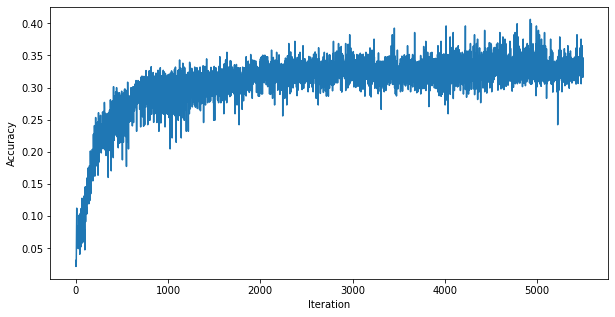

In [33]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

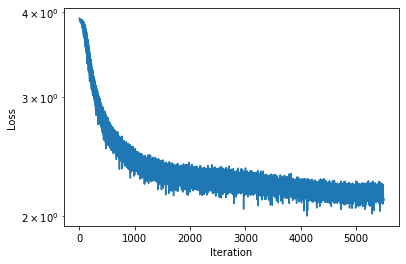

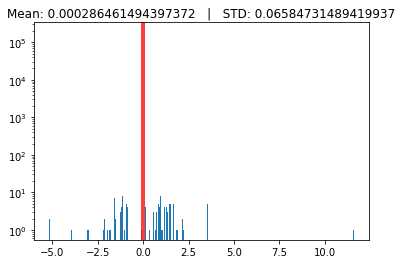

In [34]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 8.319148936170214


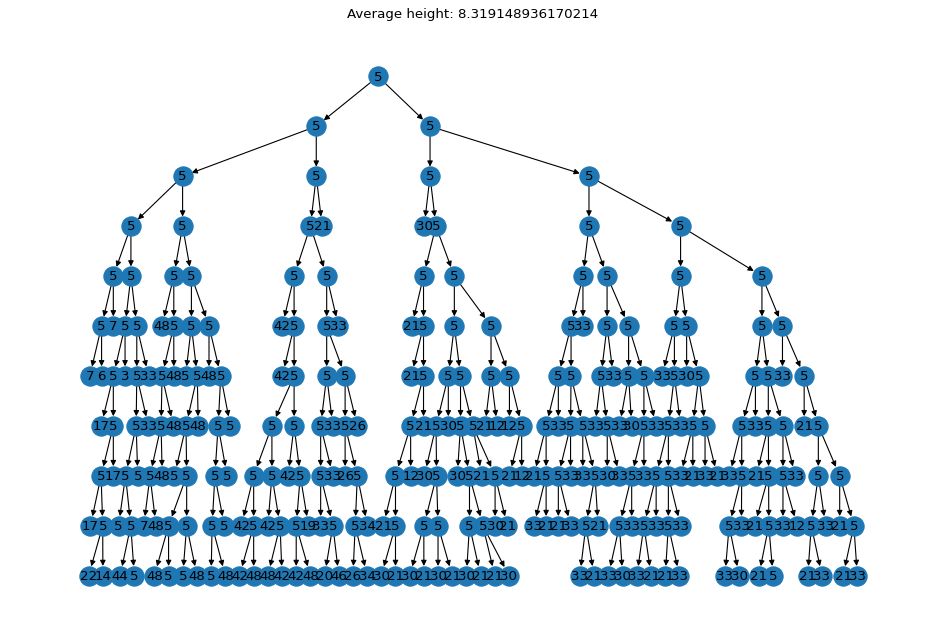

In [37]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [38]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 141


In [39]:
method = 'MLE'

In [40]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/.local/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [41]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0

for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    sum_comprehensibility += sum([cond.comprehensibility for cond in conds])
    
print(f"Average comprehensibility: {sum_comprehensibility / len(leaves)}")

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))
/home/eitan.k/.local/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
============== Pattern 25

In [1]:
# prune_tree(tree, factor=1.5)
correct = 0
tree = tree.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")

NameError: name 'tree' is not defined

In [ ]:
print(f"Sparseness: {sparseness(tree.inner_nodes.weight)}")
layer = 0
sps = []
for i in range(tree.inner_nodes.weight.shape[0]):
    cur_layer = np.floor(np.log2(i+1))
    if cur_layer != layer:
        print(f"layer {layer}: {np.mean(sps)}")
        sps = []
        layer = cur_layer
    
    x_ = tree.inner_nodes.weight[i, :]
    sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
    sps.append(sp)

## Prune the weights

In [ ]:
weights = tree.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}\n Kurtosis: {kurtosis(weights_layer)}")
    plt.yscale("log")
    plt.show()

## Verify that the accuracy didn't change too much

In [ ]:
correct = 0
tree_copy = tree_copy.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree_copy.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")


In [ ]:
weights = tree_copy.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
    plt.yscale("log")
    plt.show()

In [ ]:

stack = LifoQueue()
edge_stack = LifoQueue()
stack.put(root)
rule_counter = 0
root.reset()
while not stack.empty():
    node = stack.get()
    if node.is_leaf():
        print(f"============== Rule {rule_counter} ==============")
        for stack_node, cond in zip(stack.queue, edge_stack.queue[1:]):
            print(repr(stack_node.get_condition(attr_names)) + cond)
            print()
        
        rule_counter += 1
        edge_stack.get()
        continue
          
    if node.left is not None and not node.left.visited:
        stack.put(node)
        stack.put(node.left)
        node.left.visited = True
        edge_stack.put(' < 0')
        continue
        
    if node.right is not None and not node.right.visited:
        stack.put(node)
        stack.put(node.right)
        node.right.visited = True
        edge_stack.put(' > 0')
        continue
        
    if node is not root:
        edge_stack.get()